In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set()
sns.set_context('paper', font_scale=1.5)
sns.set_style("whitegrid")

In [3]:
mpl.rcParams['figure.figsize'] = [10, 7]
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.3

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.family'] = 'DeJavu Serif'

In [4]:
BPATH = "/home/dan/edu/uni/diplomka/tex/Images/charted/"

# Global plot func

In [5]:
import os

def savef(name):
    plt.tight_layout()
    plt.savefig(os.path.join(BPATH, name))

In [6]:
def plot_s1(x, y, title, xlabel, ylabel, *args, **kwargs):
    plt.figure()
    plt.plot(x, y, *args, **kwargs)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Trajectory

In [7]:
N = 250
SEED = 123

In [8]:
from kfsims.trajectory import trajectory
trj = trajectory(SEED, N)
true_traj = trj.X.T
cov_traj = trj.R

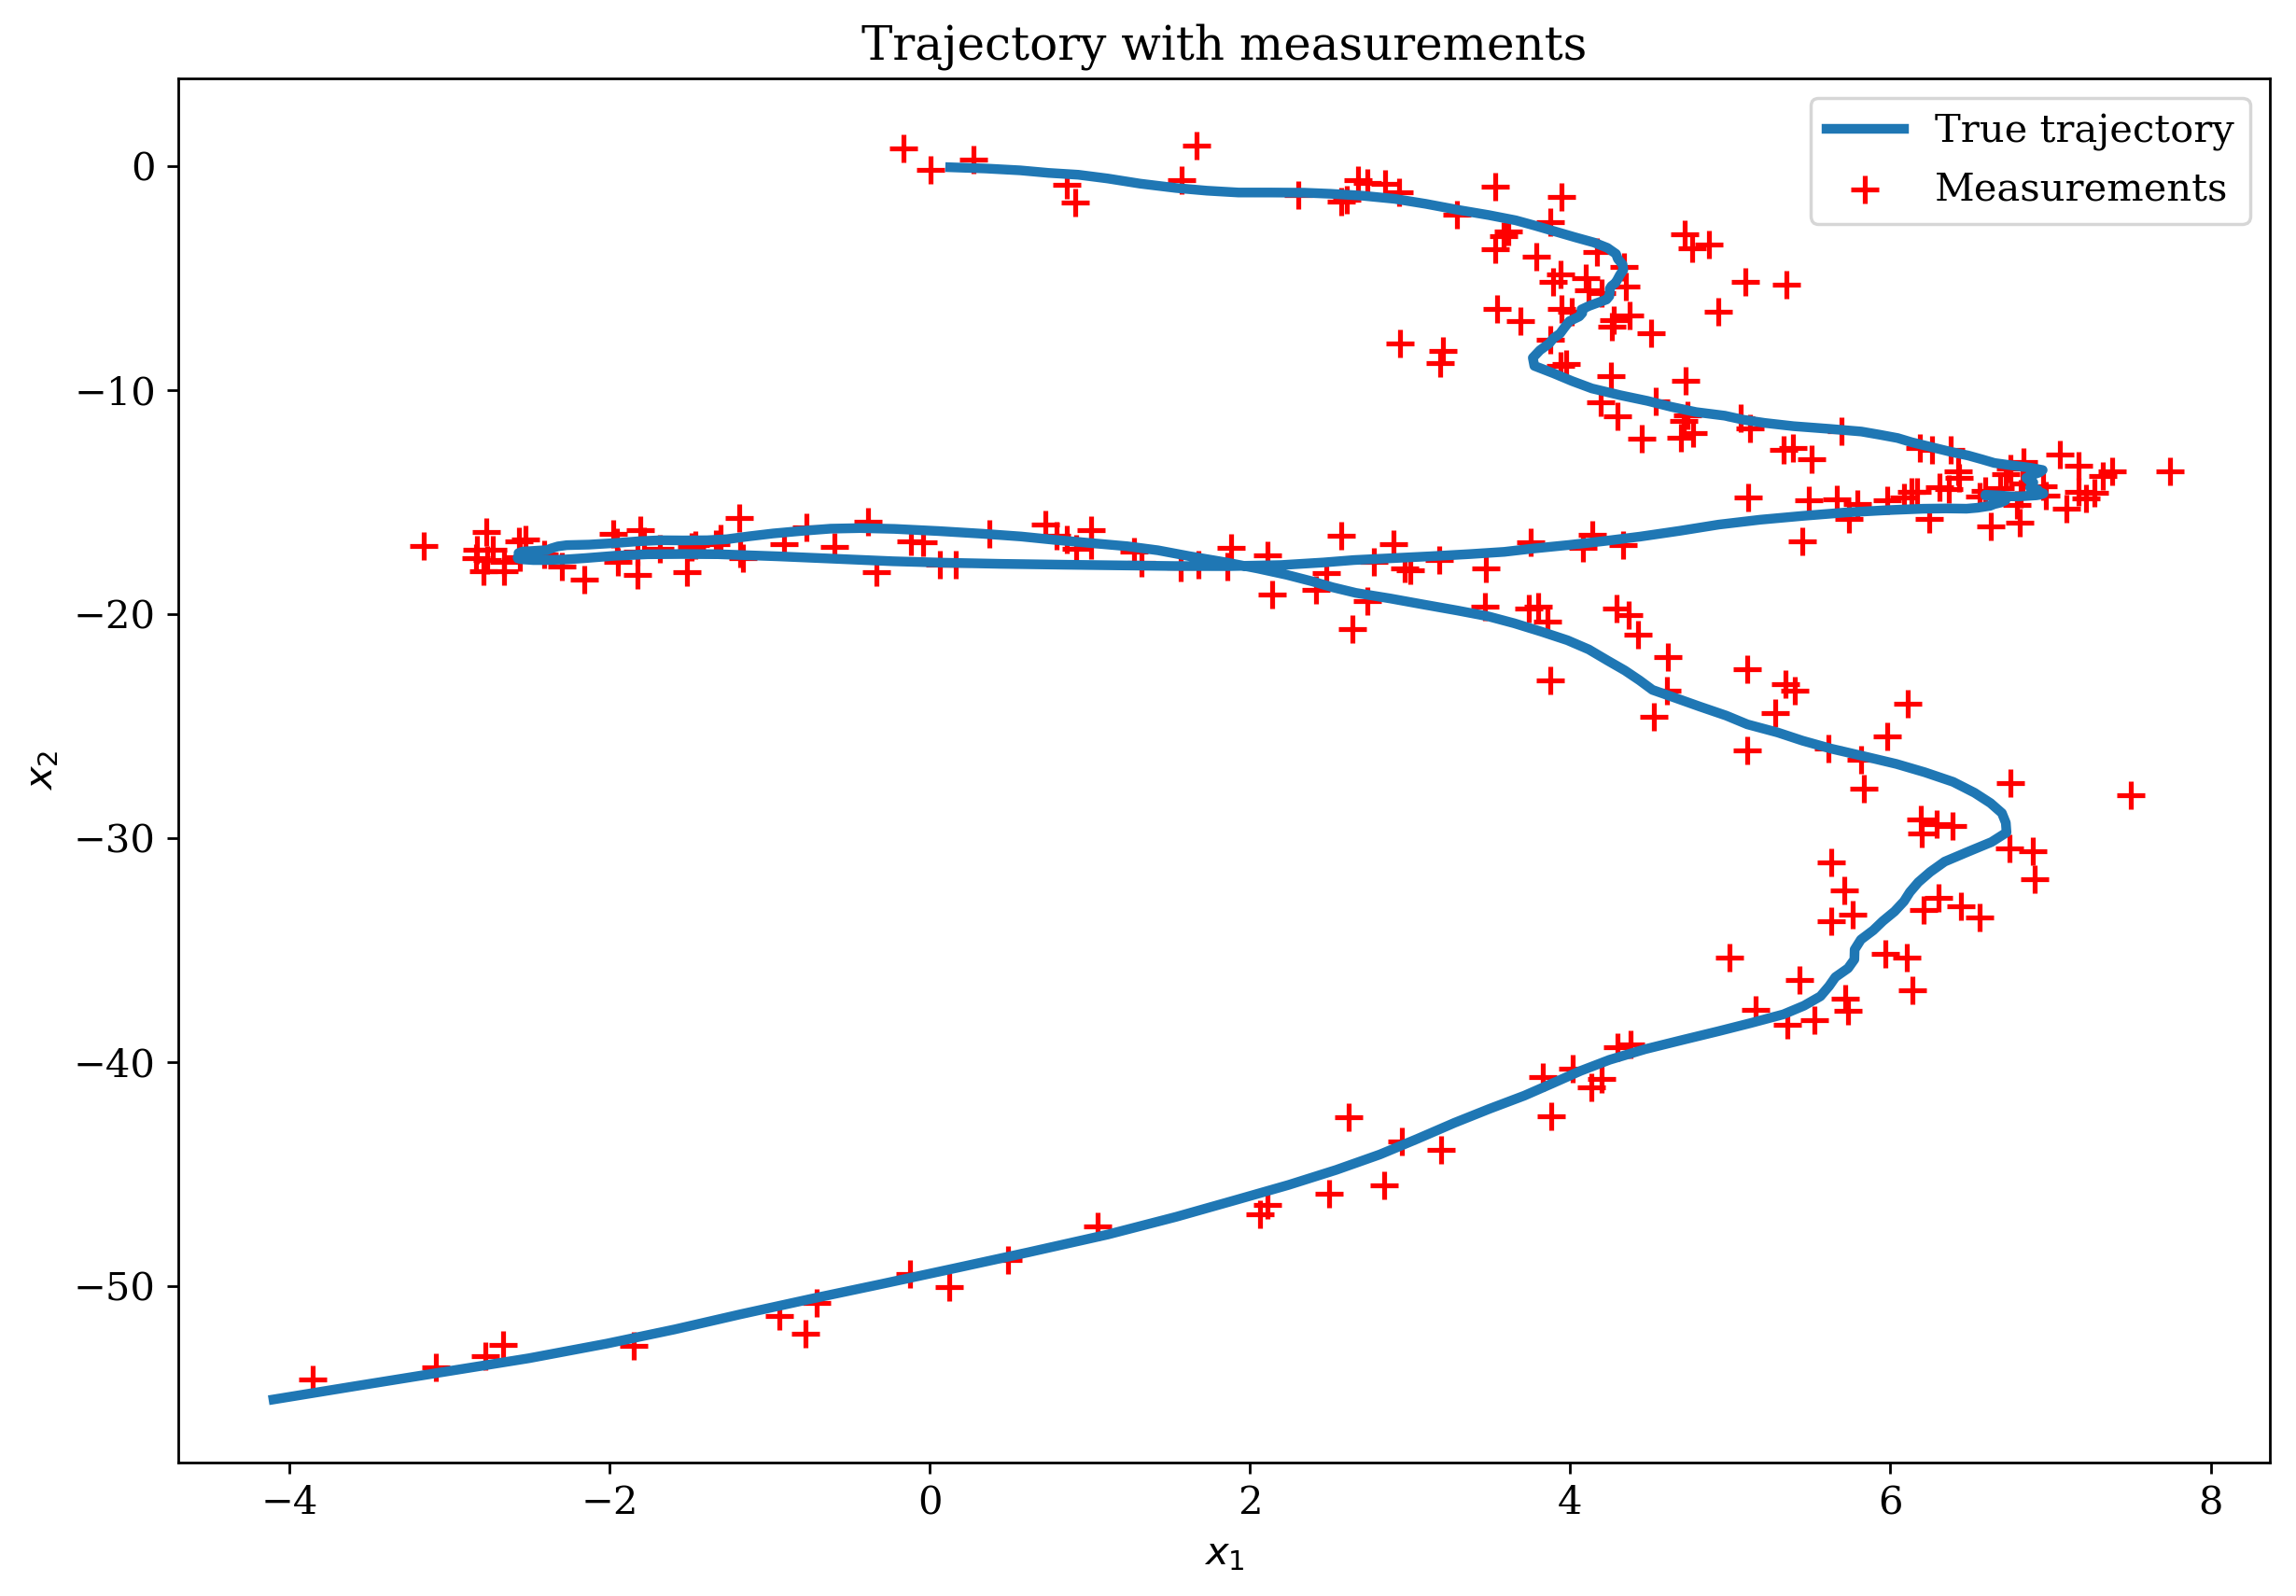

In [9]:
plot_s1(trj.X[0, :], trj.X[1, :], 
        'Trajectory with measurements',
        '$x_1$',
        '$x_2$',
        label='True trajectory',
        lw=3
       )
plt.scatter(trj.Y[0, :], trj.Y[1, :], marker='+', c='red', label='Measurements', s=70)
plt.legend()
savef('trajectory.pdf')

<Figure size 2500x1750 with 0 Axes>

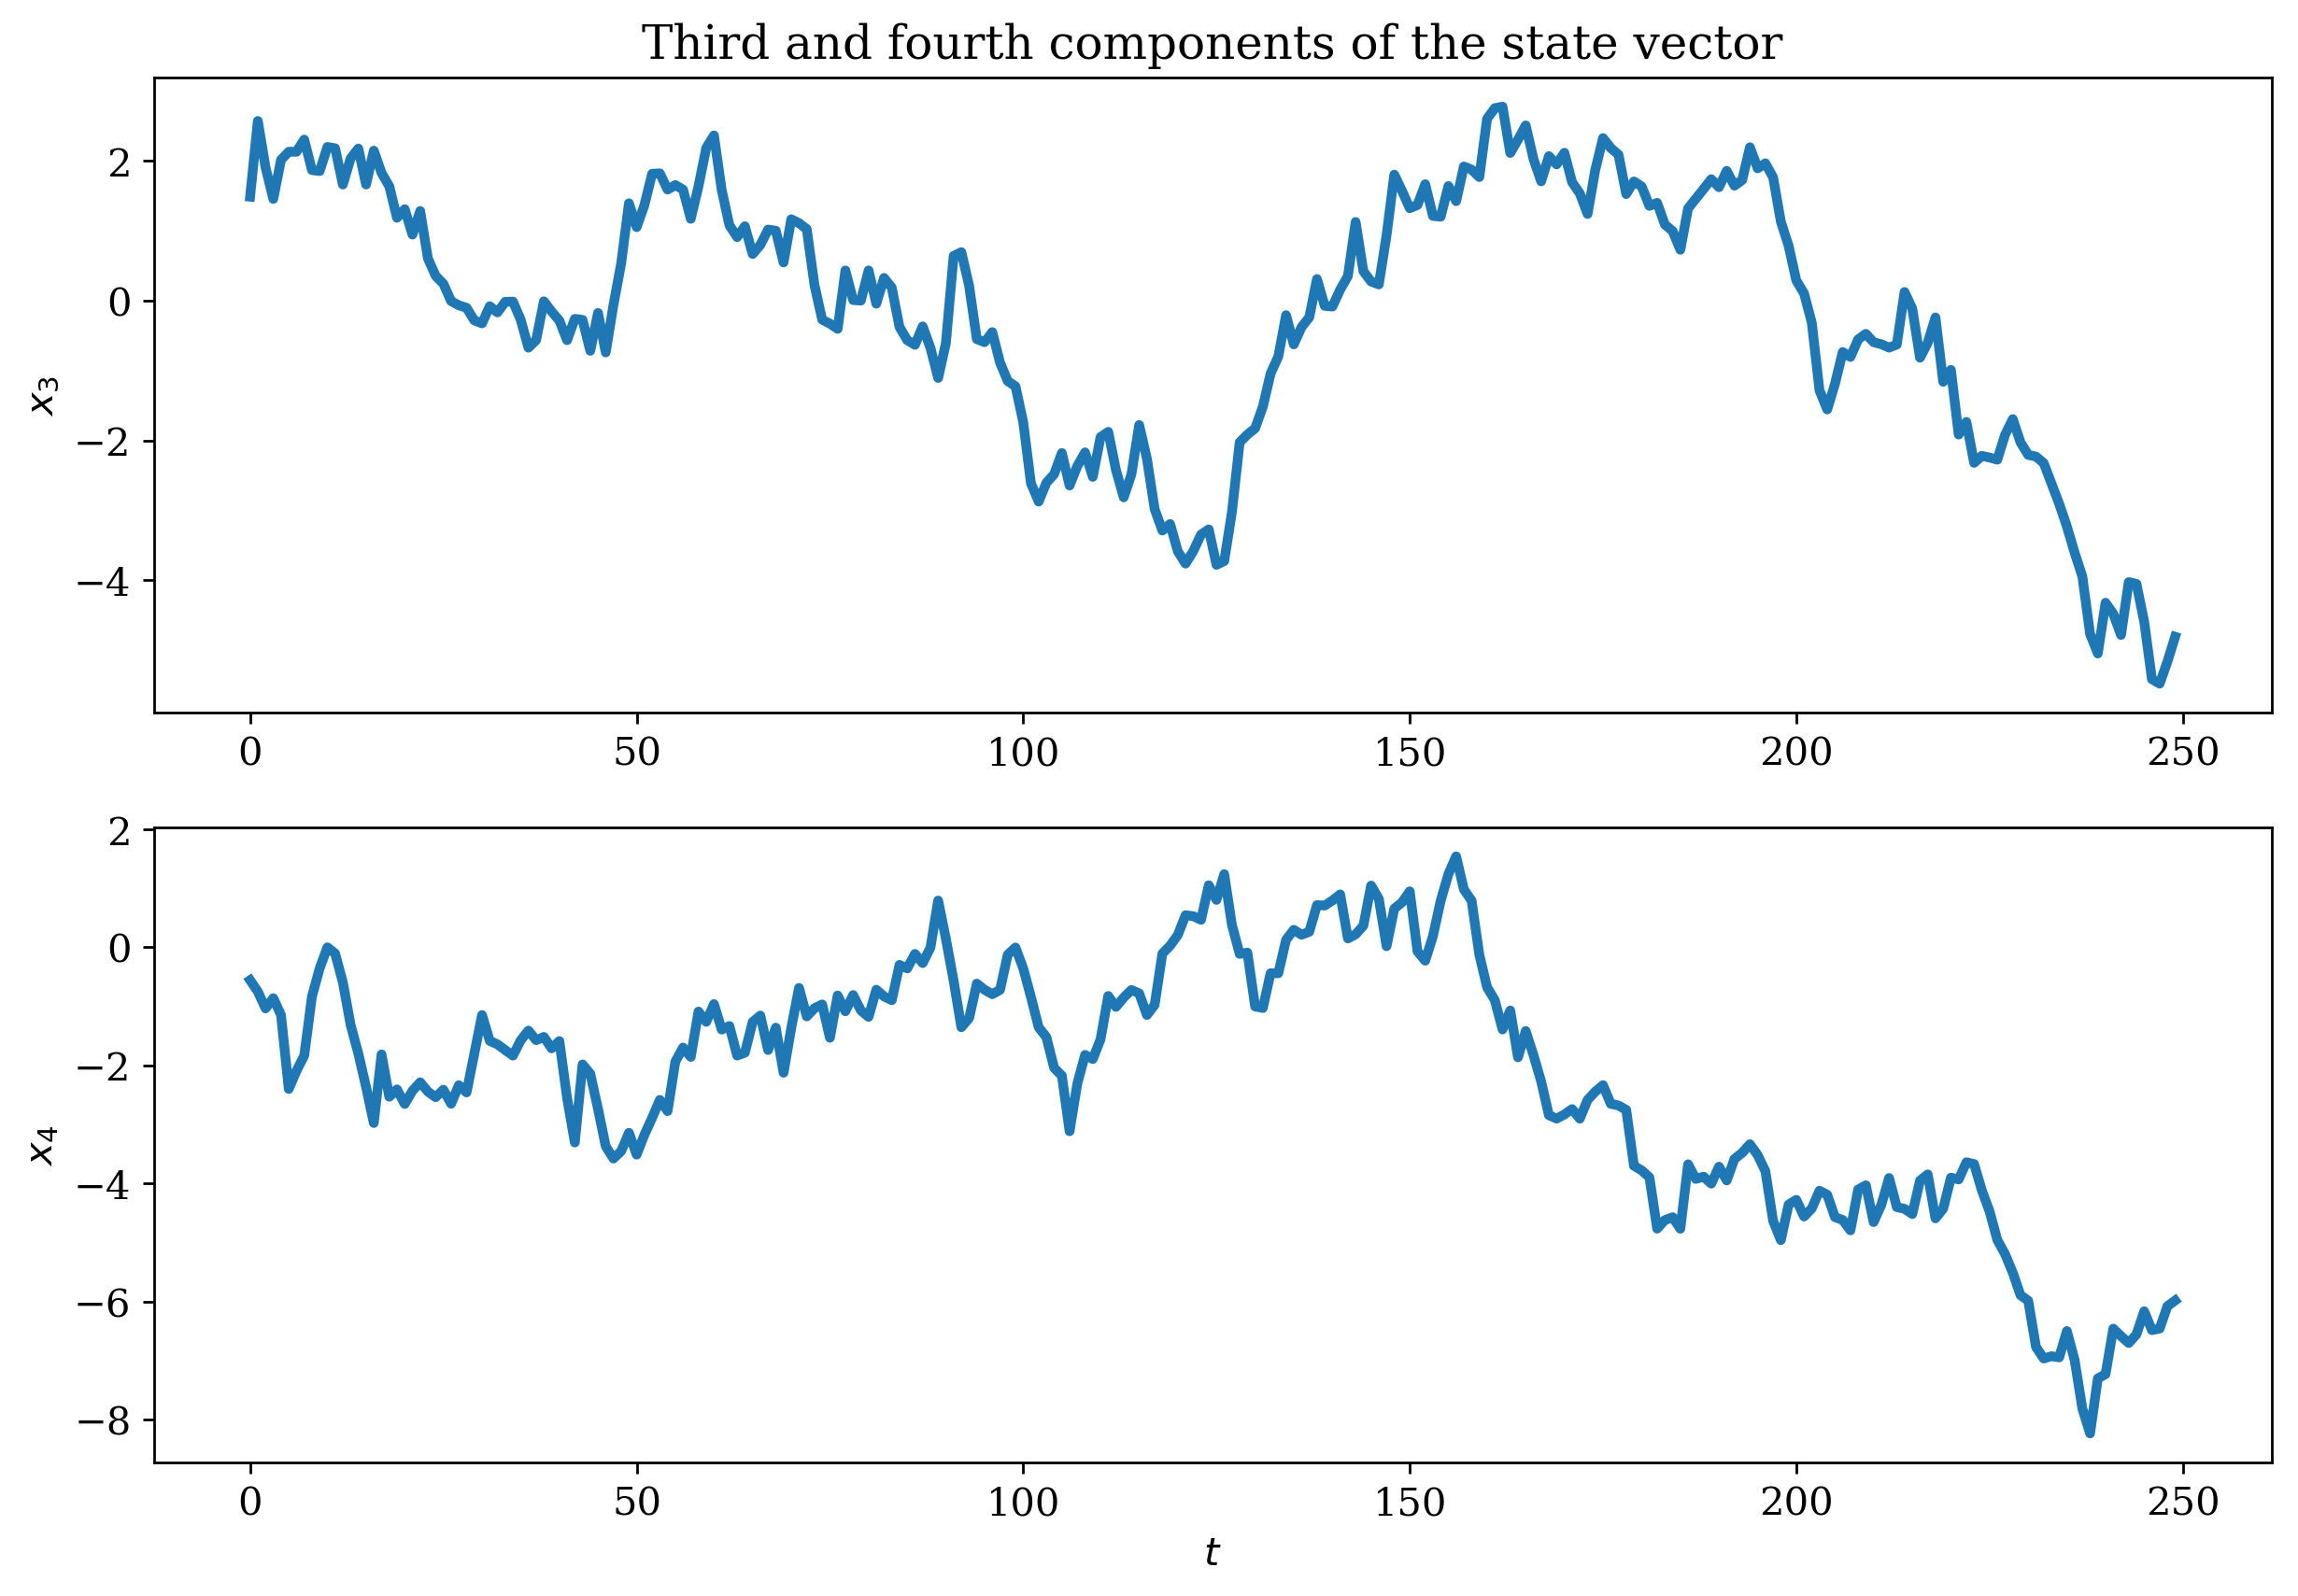

In [10]:
plt.figure()

f, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(trj.X[2, :], lw=3)
ax1.set_ylabel('$x_3$')
ax1.set_title('Third and fourth components of the state vector')

ax2.plot(trj.X[3, :], lw=3)
ax2.set_ylabel('$x_4$')
ax2.set_xlabel('$t$')

savef('3and4th-state.pdf')

# Noise

In [11]:
from kfsims import noise
import numpy as np

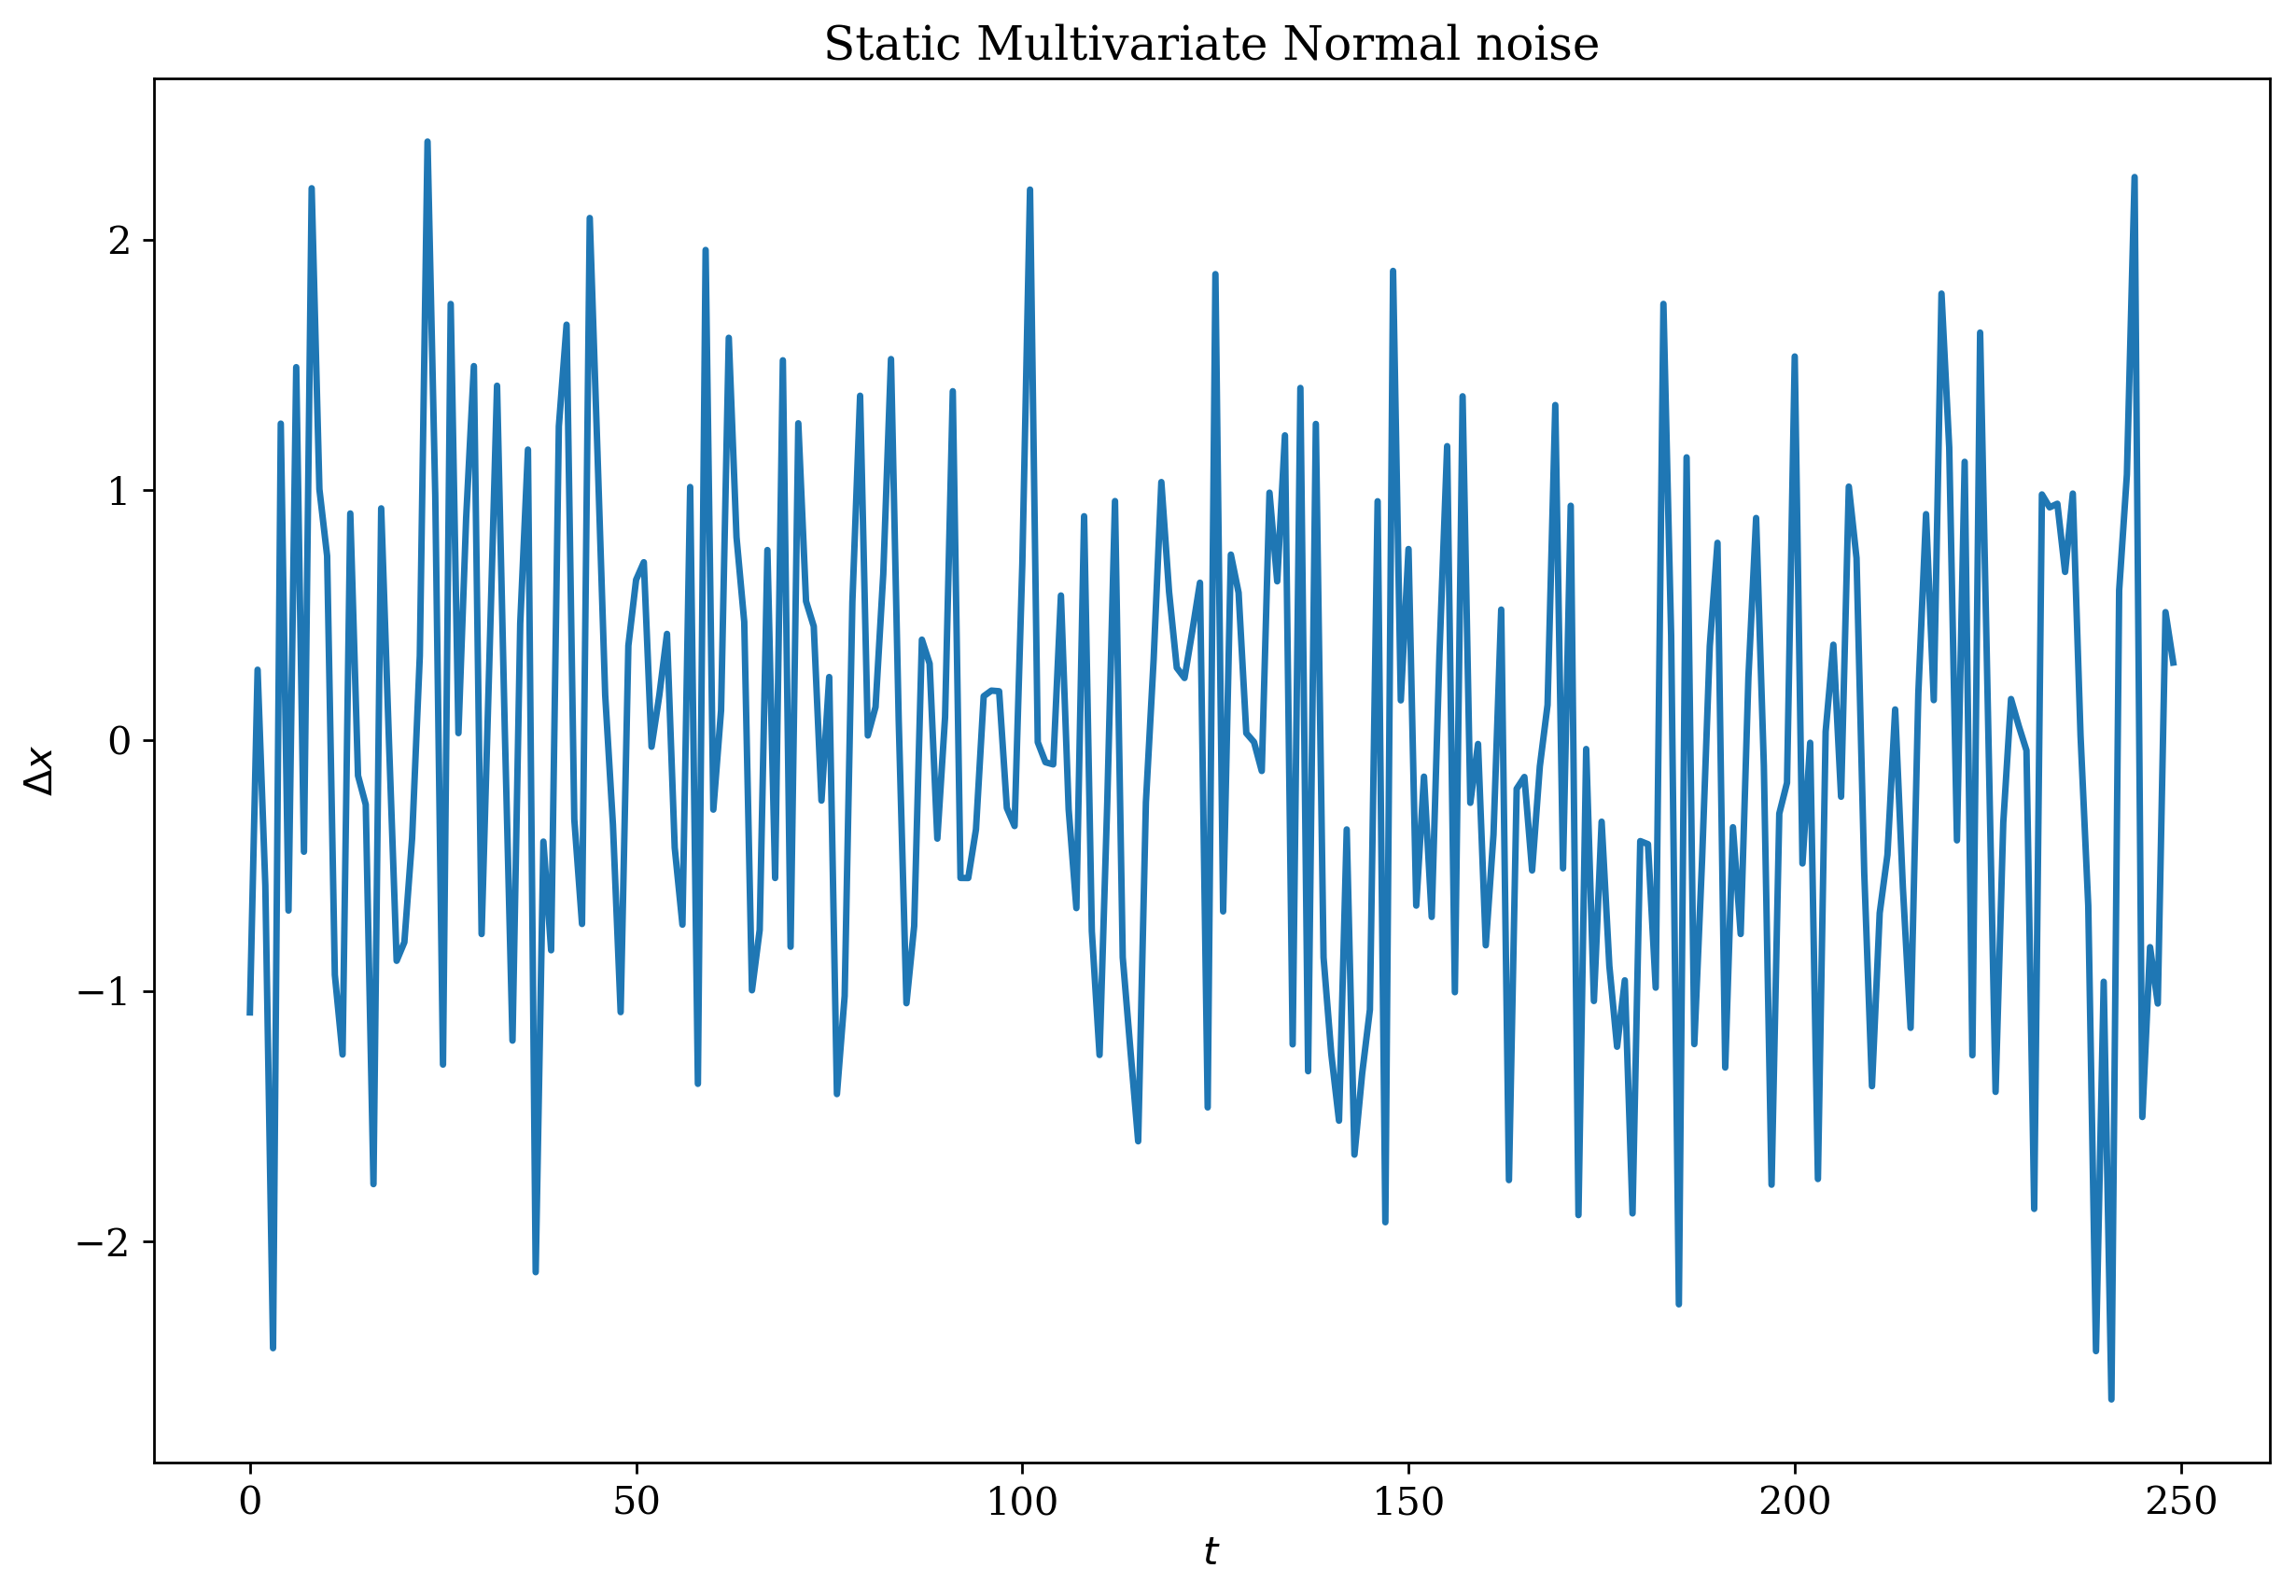

In [12]:
np.random.seed(SEED)
n_static = noise.static_noise(N)
x1 = n_static[:, 0]
plot_s1(range(len(x1)), x1, title='Static Multivariate Normal noise', xlabel='$t$', 
        ylabel="$\Delta x$", lw=2)
savef('static-noise.pdf')

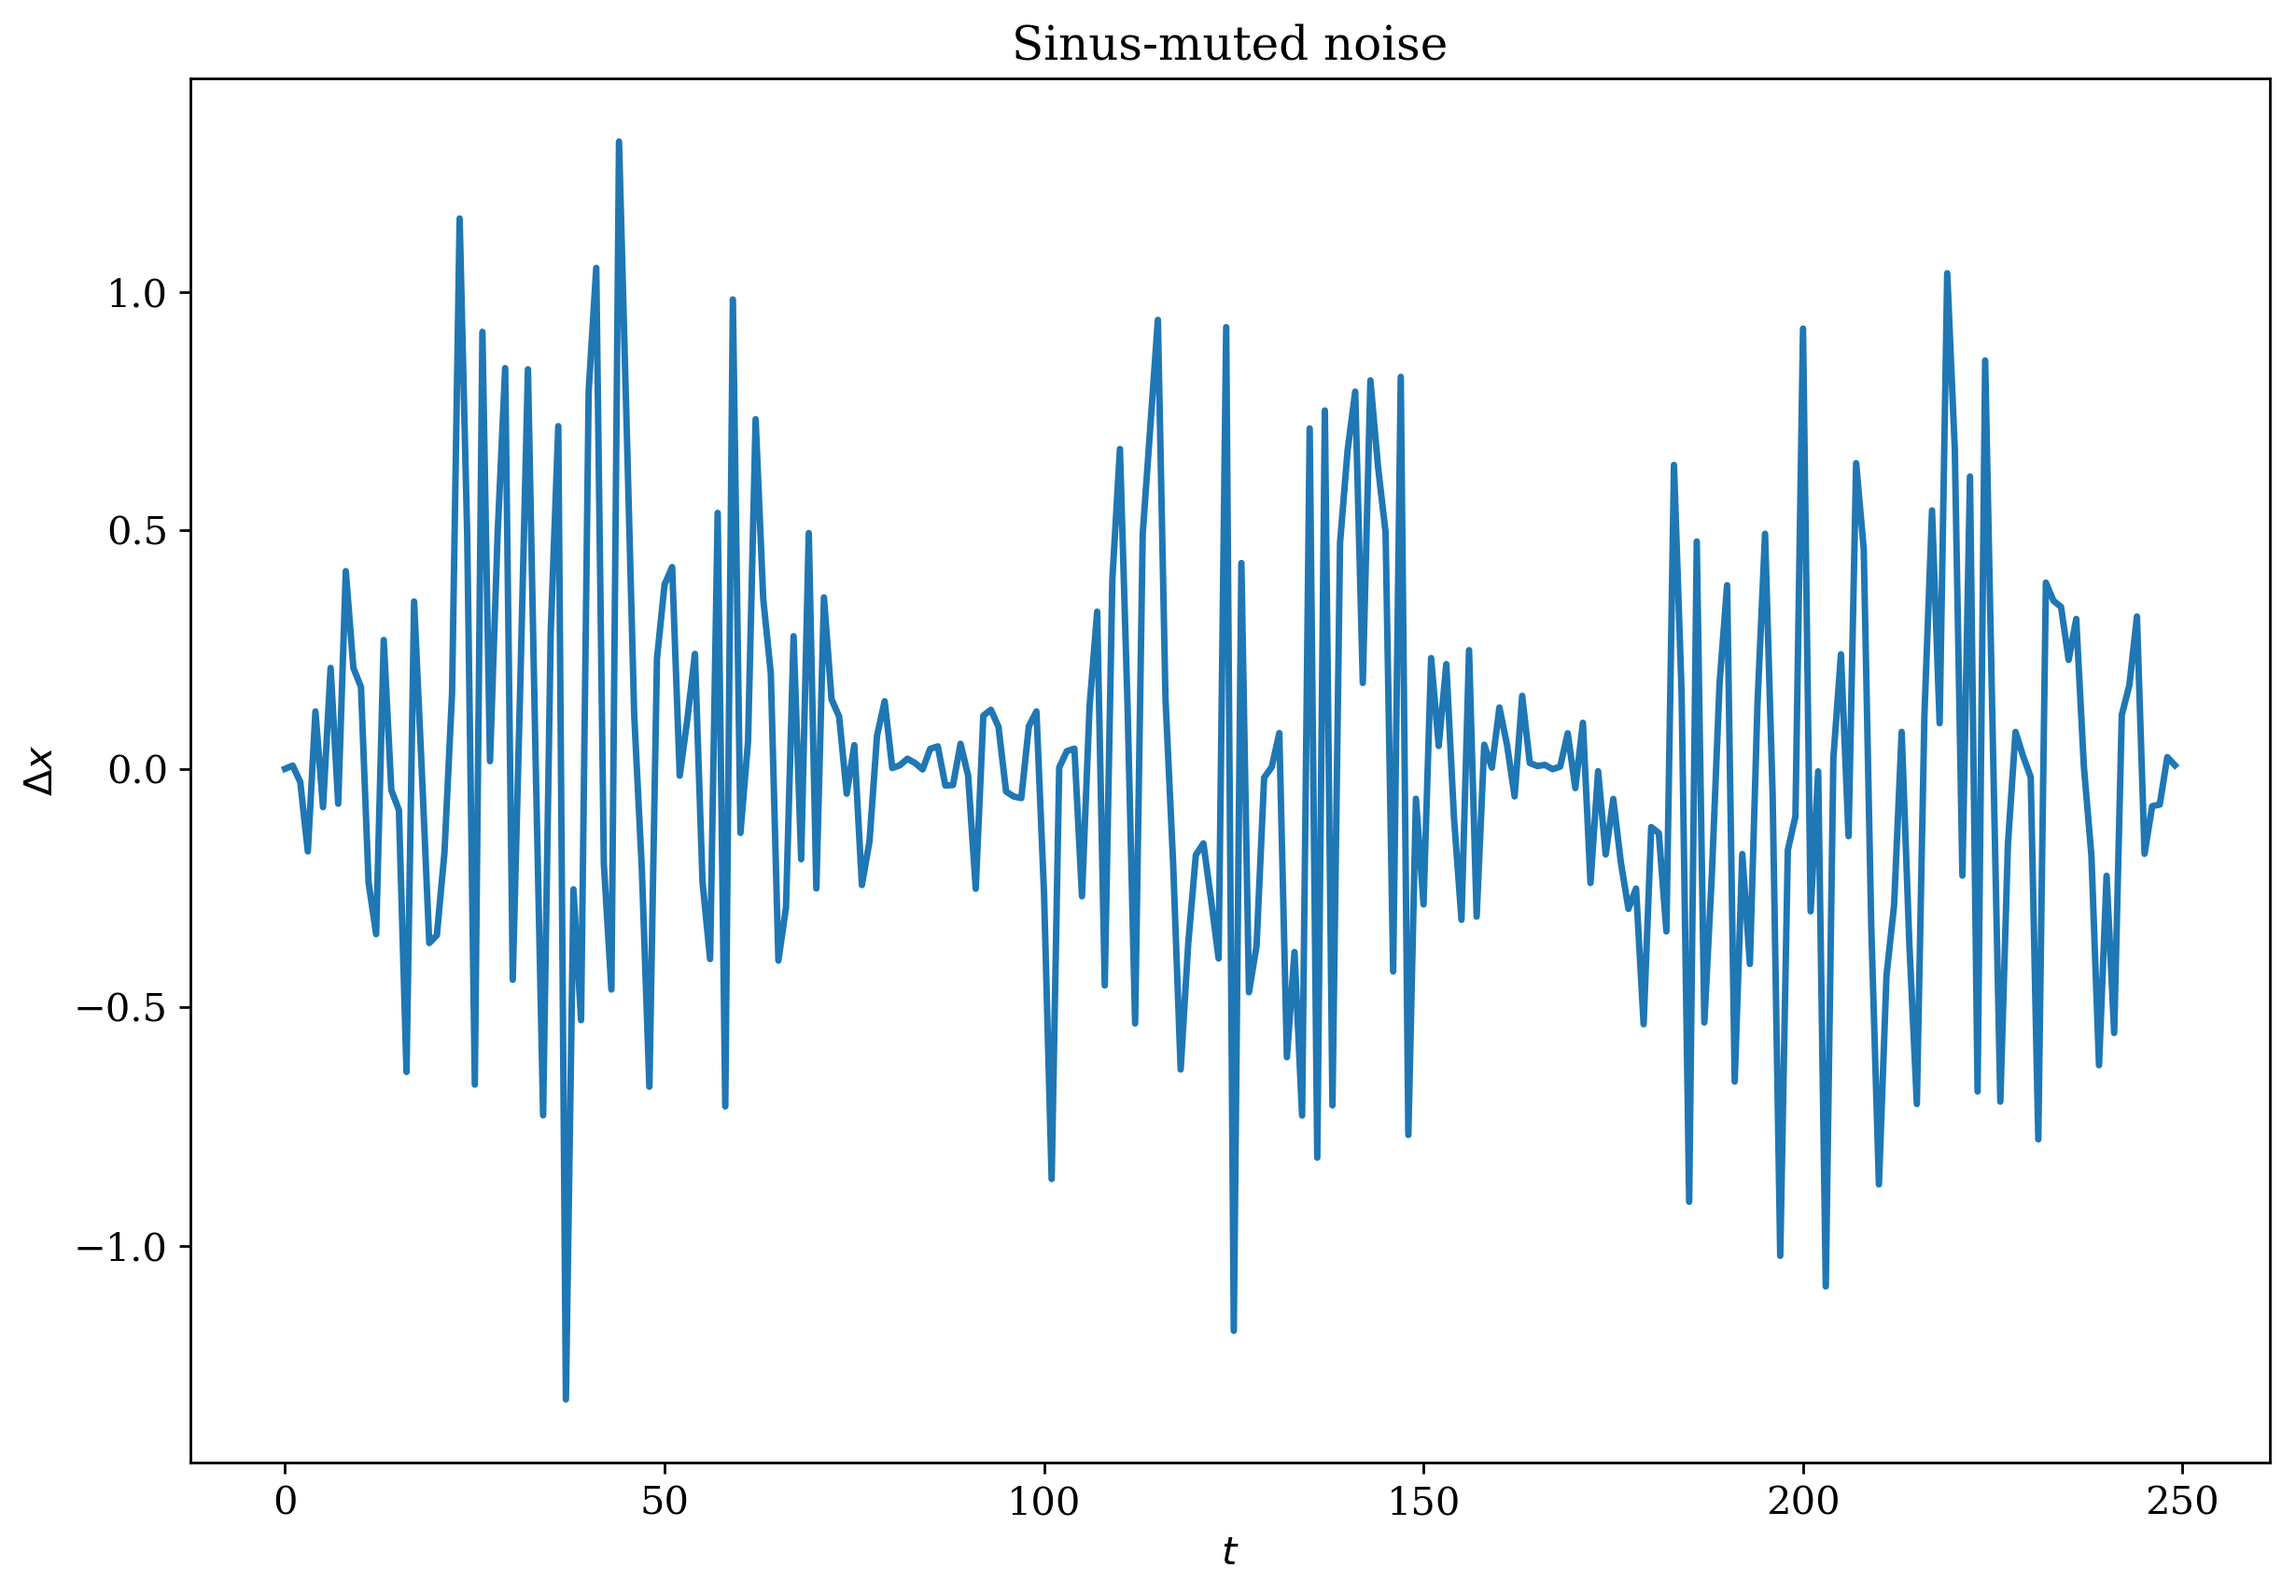

In [13]:
np.random.seed(SEED)
n_sin = (noise.static_noise(N, mod=0.4) * noise.sin_noise(N, 3))[:, 0]
plot_s1(range(len(n_sin)), n_sin, title='Sinus-muted noise', 
        xlabel='$t$', 
        ylabel="$\Delta x$", lw=2)
savef('sinus-noise.pdf')

# Known - static

In [14]:
from kfsims.utils import daniels_variant, classic_kf, plot_single, plot_variants_only, plot_variants

In [15]:
np.random.seed(10)
n_static = noise.static_noise(N, mod=3)

cov_init = abs(np.cov(n_static.T)) + cov_traj# + np.eye(2)*30
msrms = trj.Y + n_static.T

res_dv, rms_dv, std_dv = daniels_variant(msrms, true_traj, cov_init)
res_kfc, rms_kfc, srd_kfc  = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv, std_dv)
print(rms_kfc, srd_kfc)

[0.59269964 0.52830738 0.92992447 1.03664405] [0.45811    0.41141149 0.82294212 0.71777891]
[0.5488607  0.50308281 0.90523009 0.91355115] [0.4443714  0.36524944 0.83414918 0.69801354]


In [16]:
cov_init

array([[3.02344422, 0.08698274],
       [0.08698274, 2.83827671]])

In [17]:
def plot_comp(plt, sl, res_dv, res_kfc, true_traj, msrms, title, ylabel, xlabel='$t$', start_pos=0):
    plot_single(plt, sl, res_dv, res_kfc, true_traj, msrms, start_pos=start_pos)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

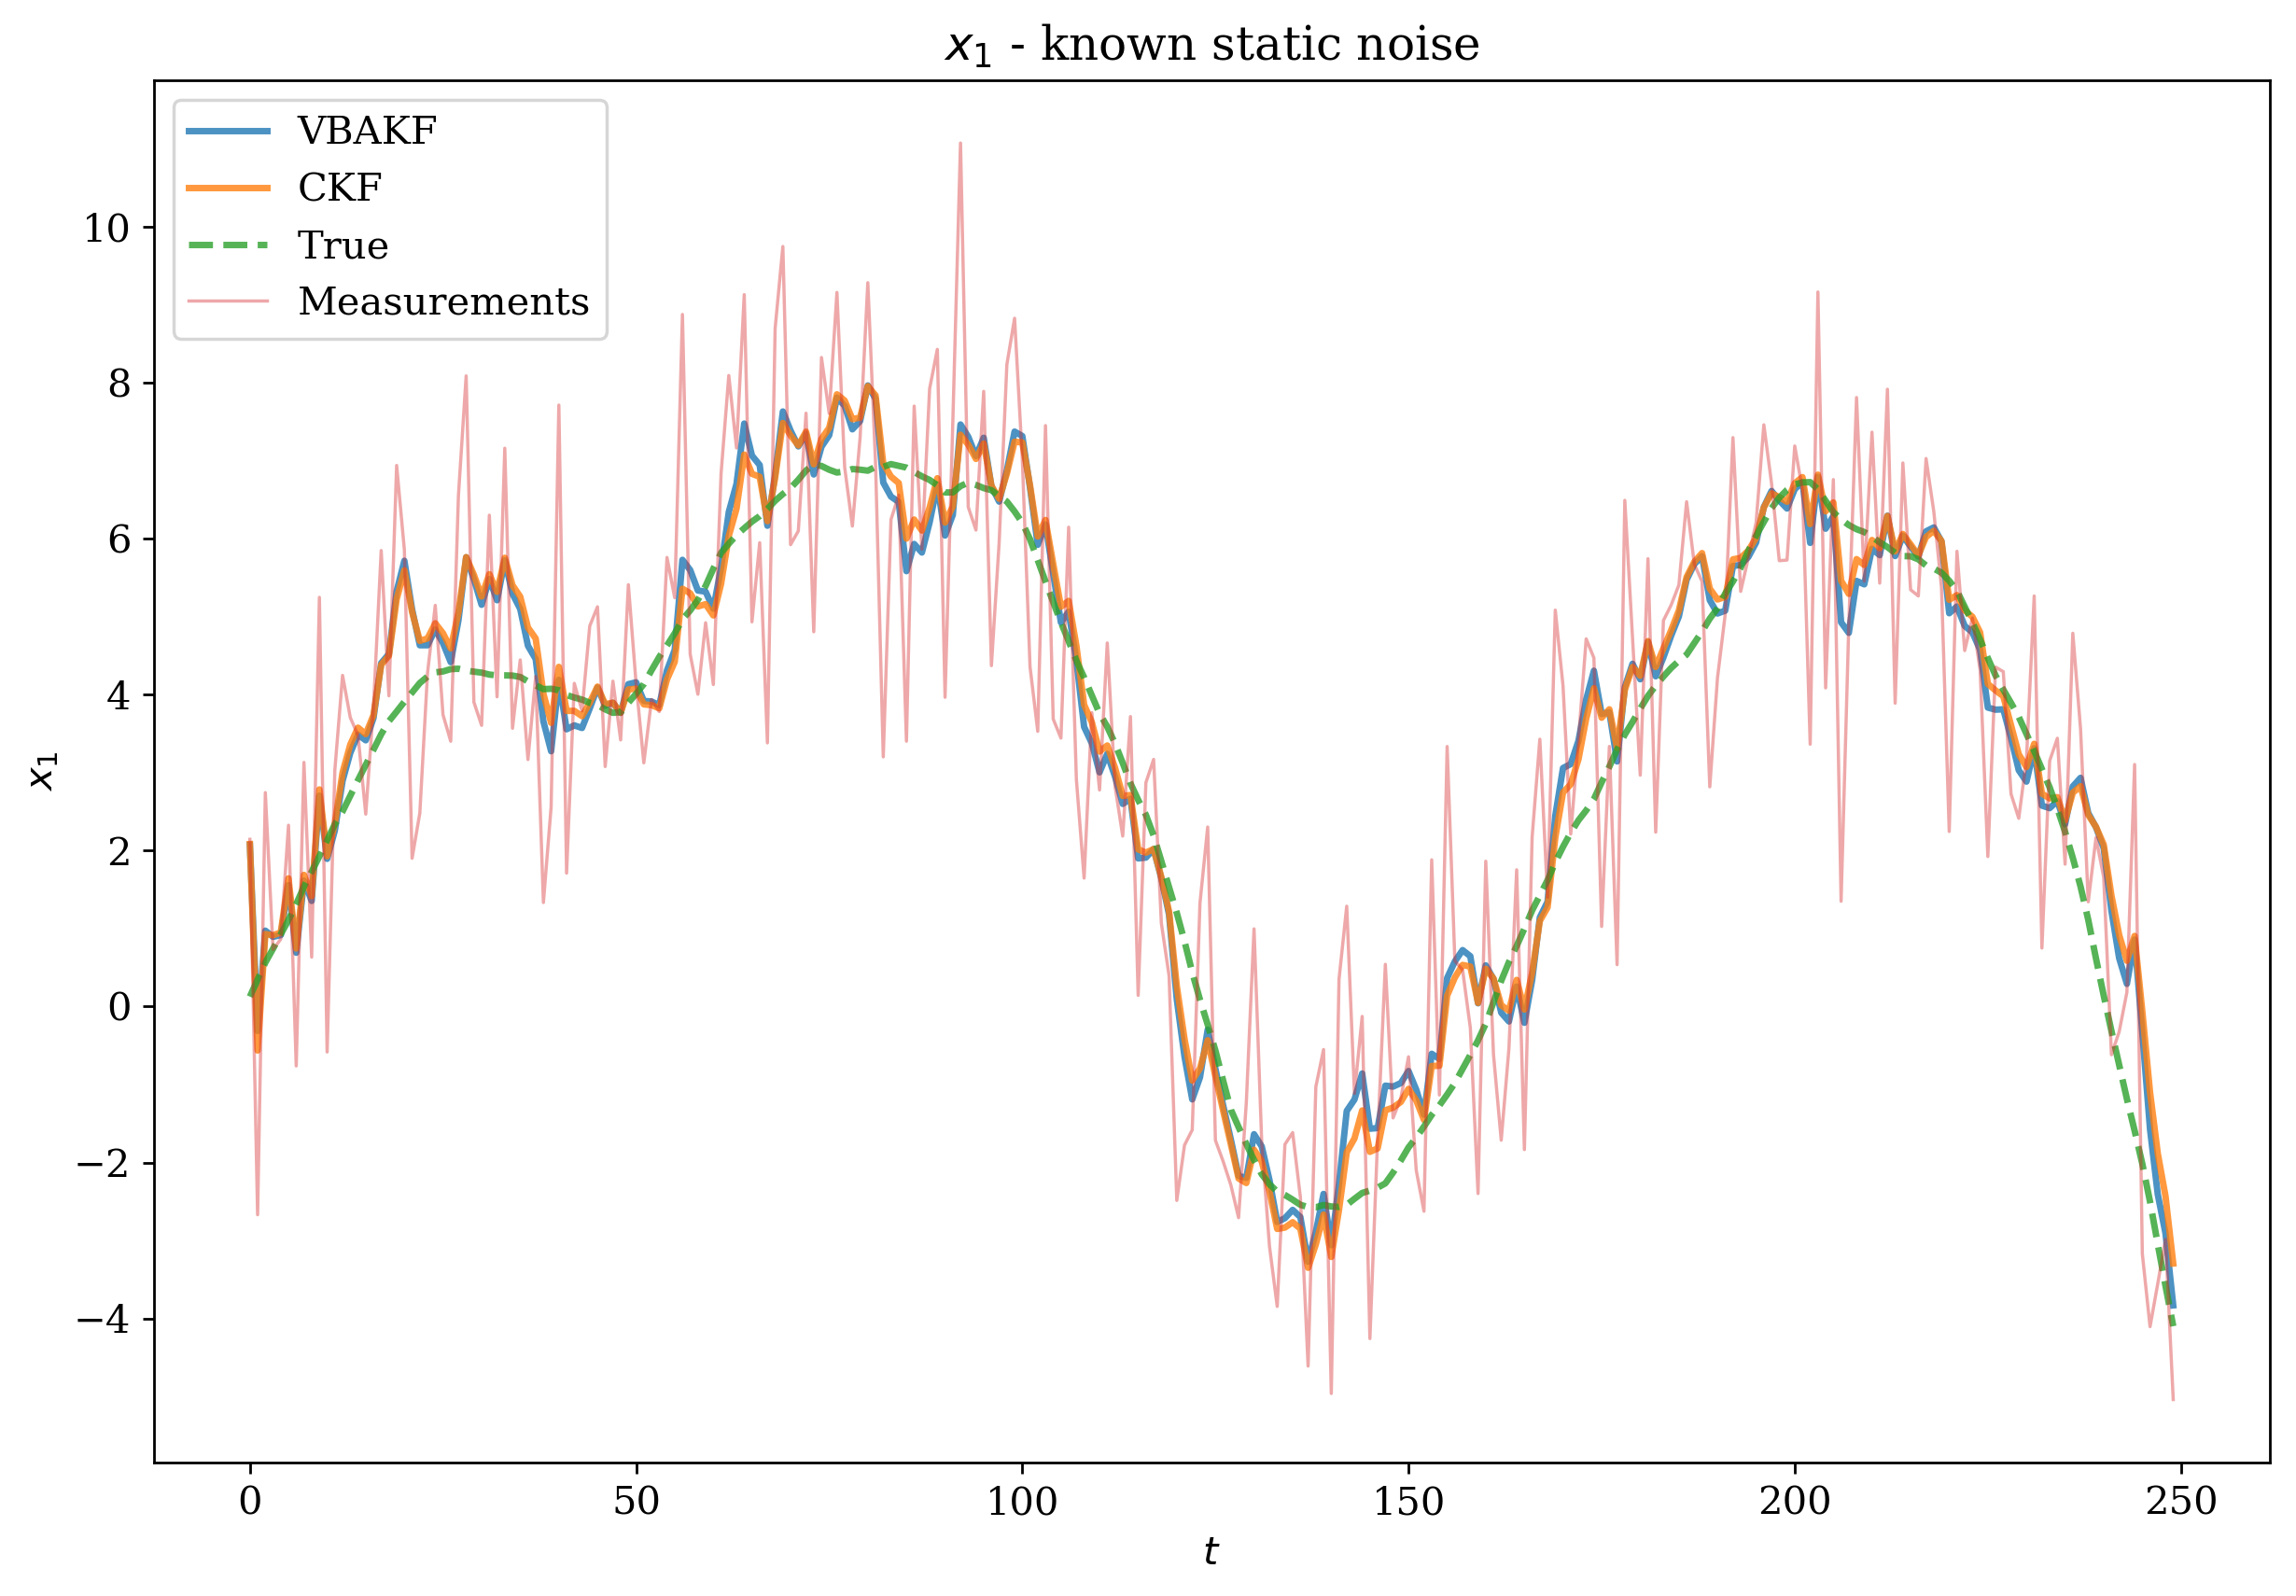

In [18]:
plot_comp(plt, 0, res_dv, res_kfc, true_traj, msrms, '$x_1$ - known static noise', '$x_1$')
savef('perf-static-known-x1.pdf')

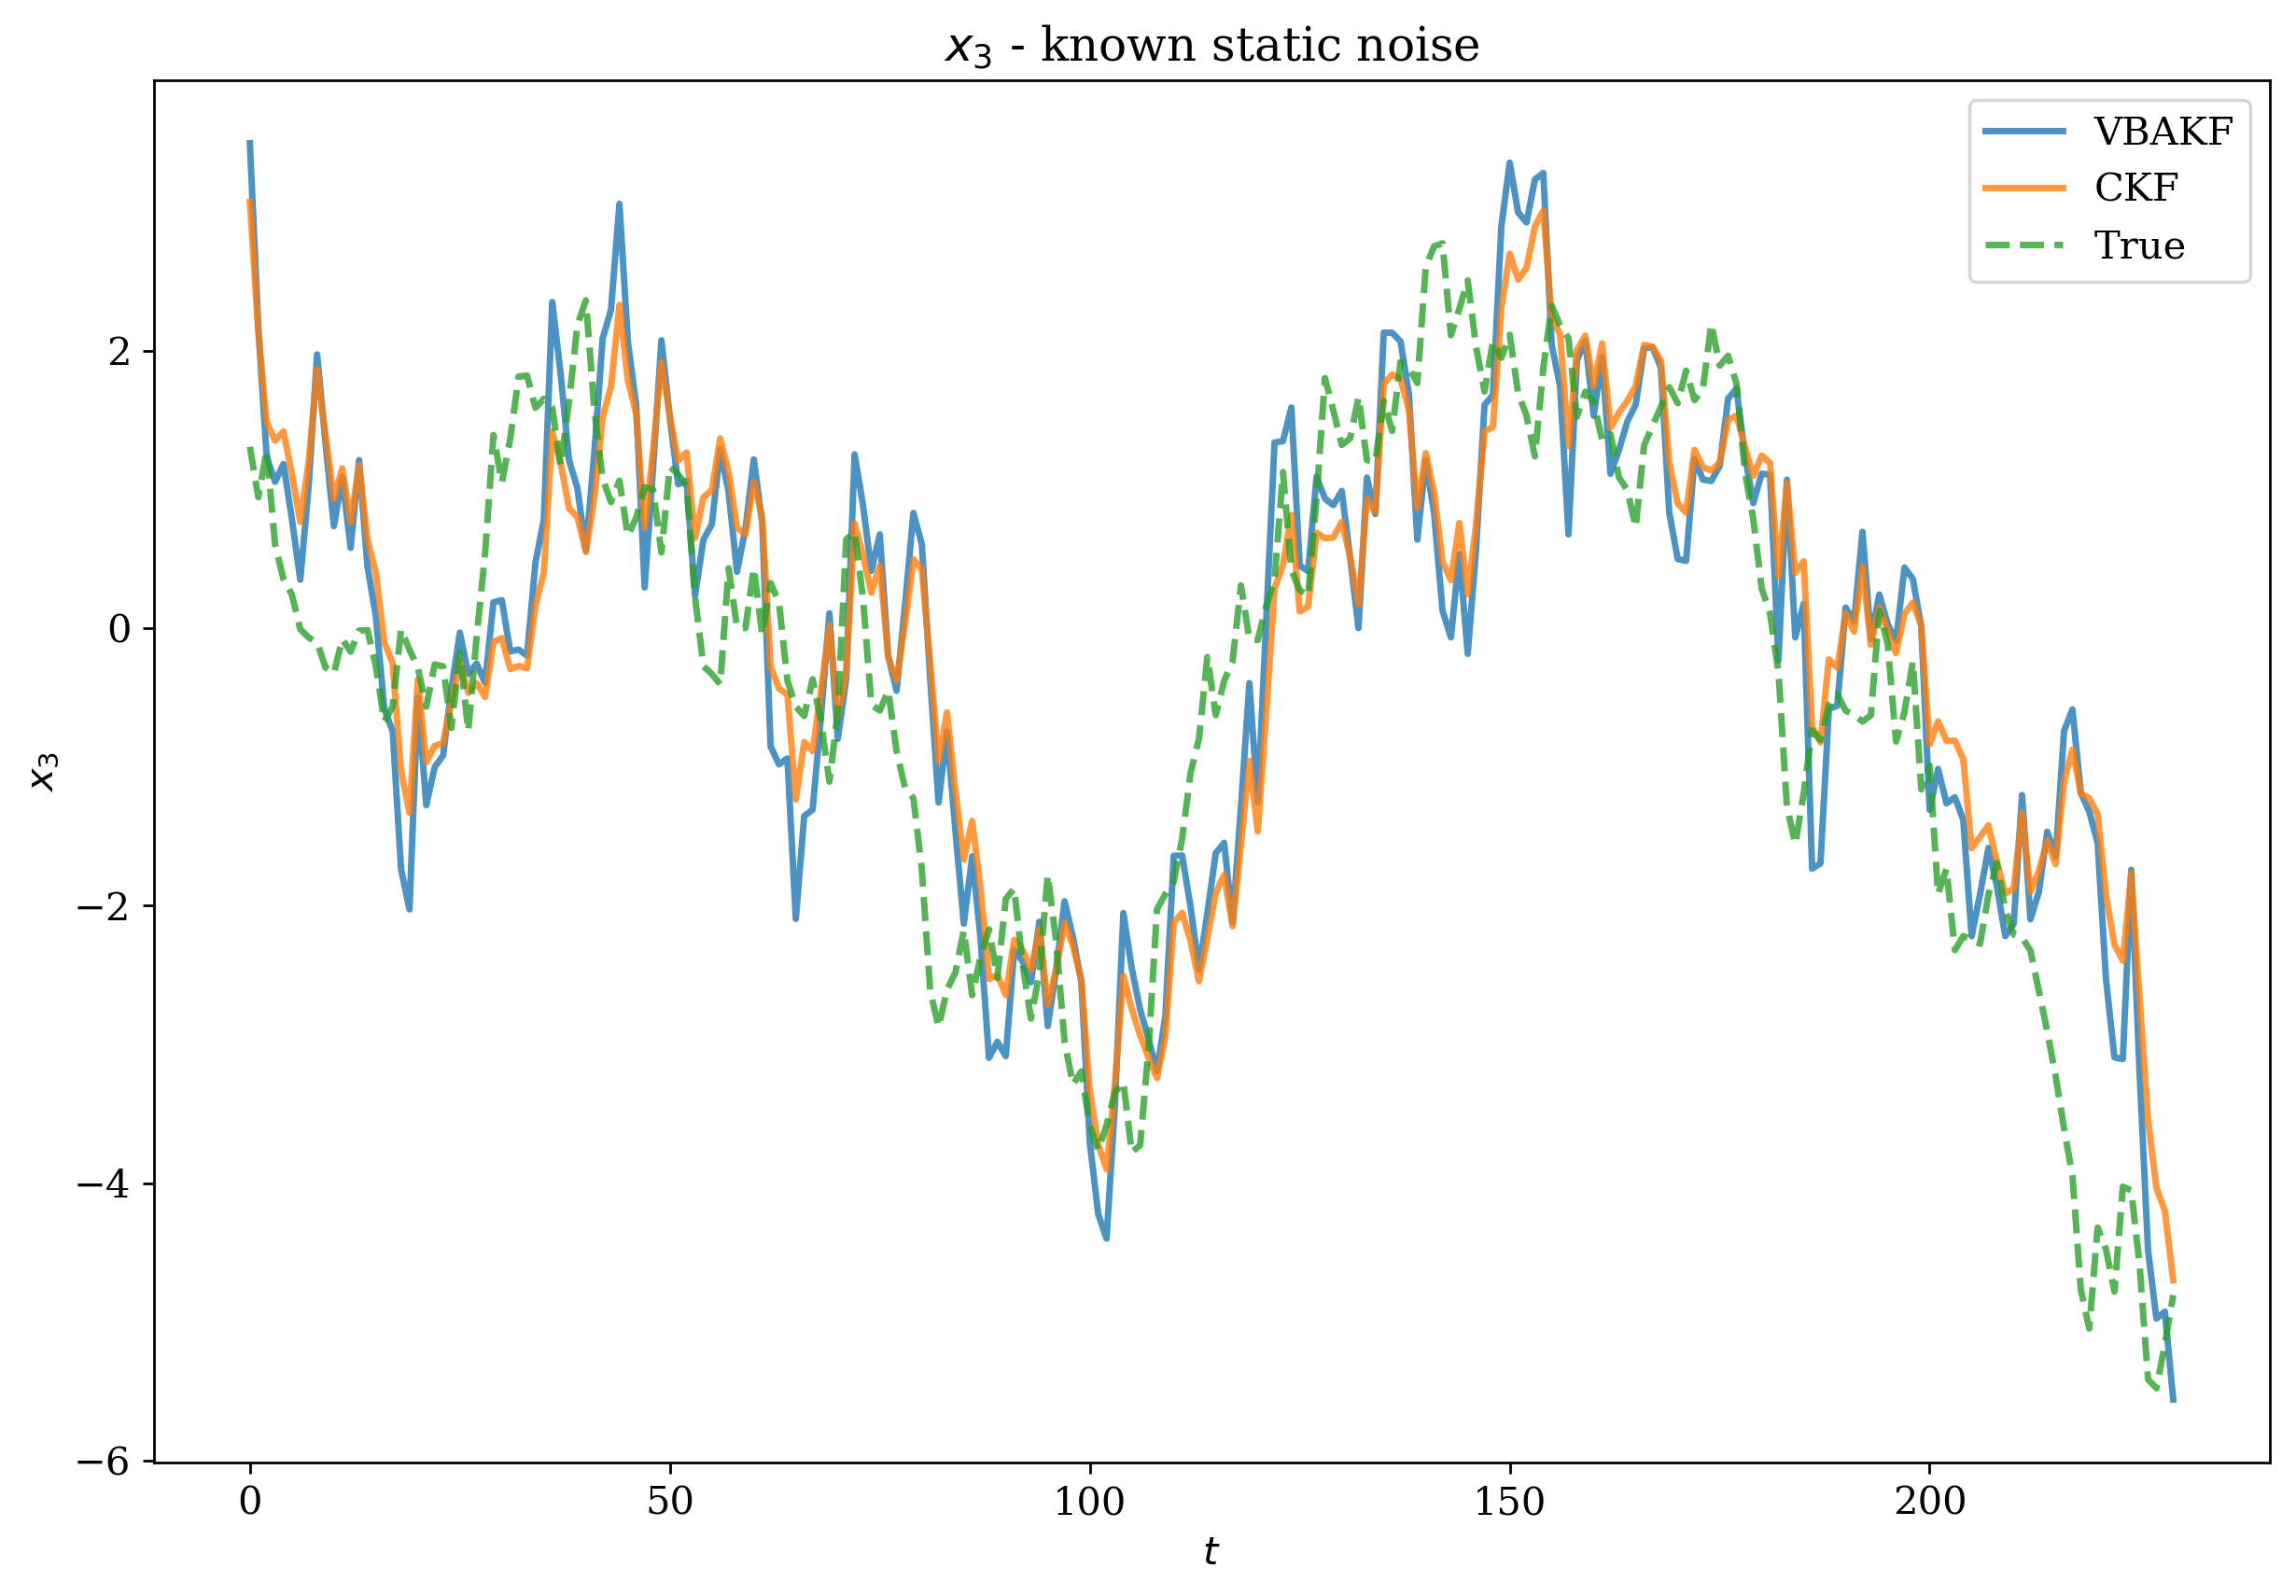

In [19]:
plot_comp(plt, 2, res_dv, res_kfc, true_traj, msrms=None, title='$x_3$ - known static noise', ylabel='$x_3$',
         start_pos=20)
savef('perf-static-known-x3.pdf')

# Unknown static

In [20]:
np.random.seed(10)
n_static = noise.static_noise(N, mod=3)

cov_init = abs(cov_traj) # np.cov(n_static.T)
msrms = trj.Y + n_static.T

res_dv, rms_dv, std_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.99)
res_kfc, rms_kfc, srd_kfc  = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv, std_dv)
print(rms_kfc, srd_kfc)

[0.60425179 0.58123922 1.07194077 1.15130775] [0.50240154 0.46258137 1.06411214 1.10245996]
[0.68920978 0.65140953 1.45097533 1.53674656] [0.55892571 0.498254   2.29960901 1.3672583 ]


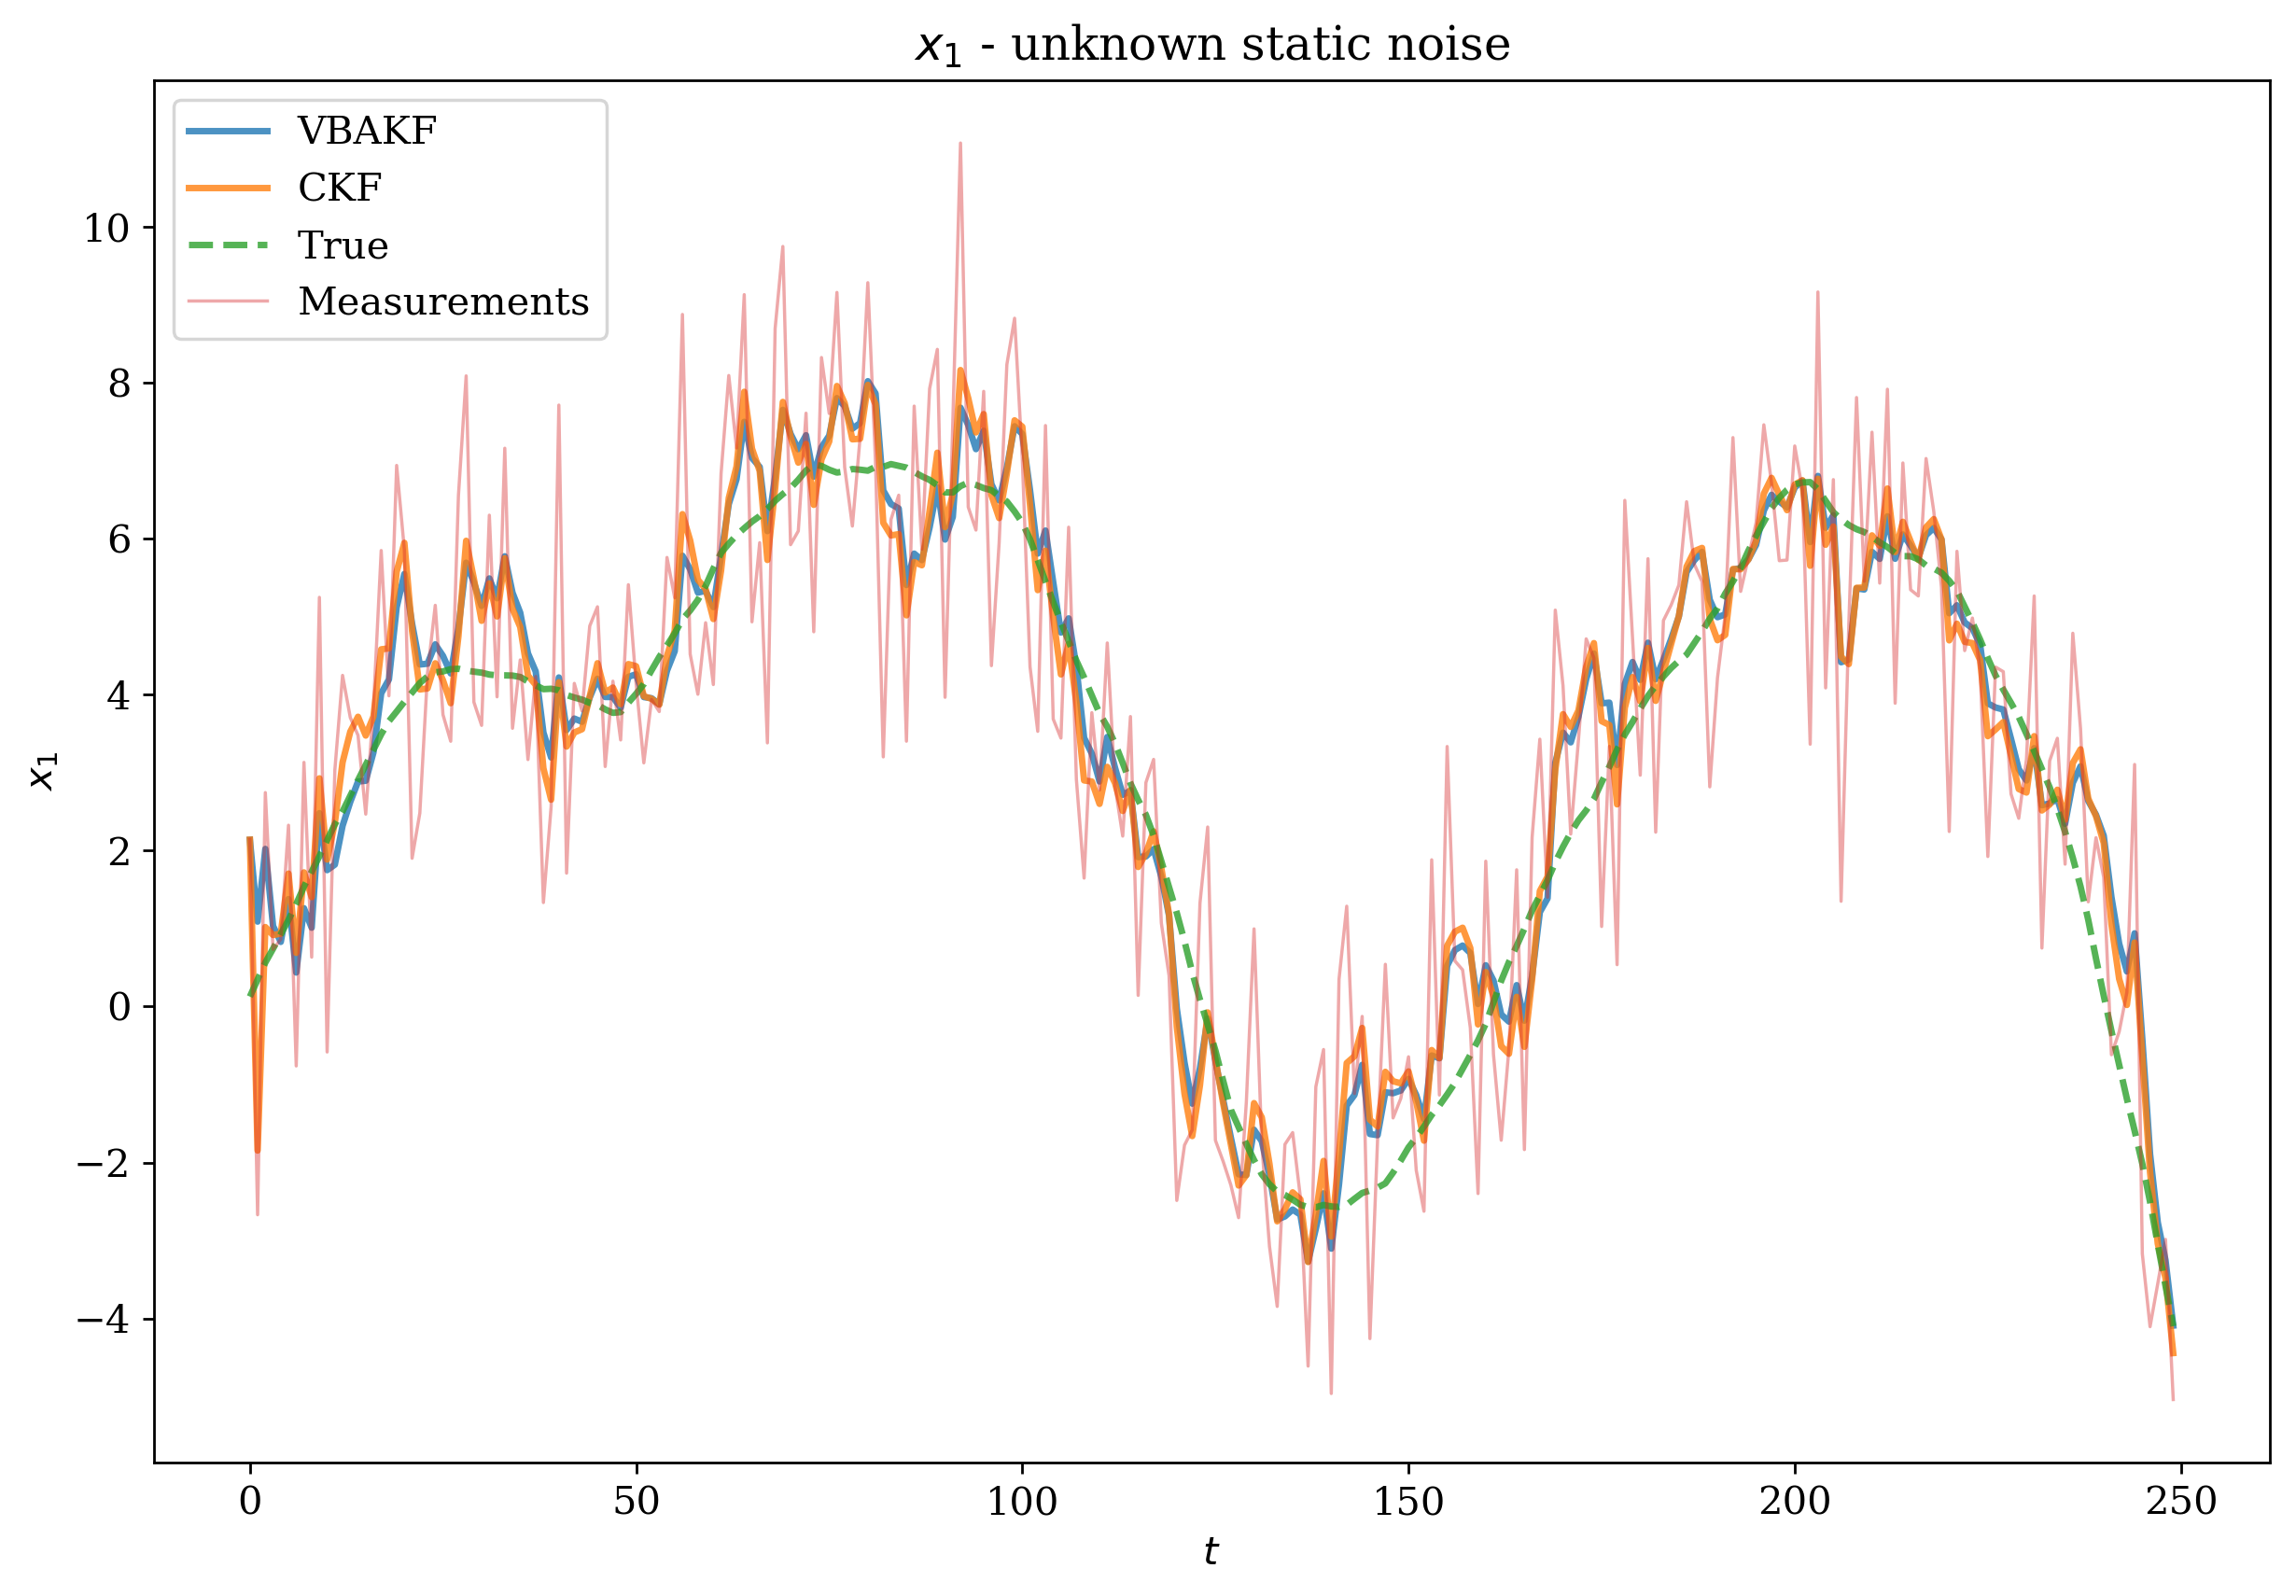

In [21]:
plot_comp(plt, 0, res_dv, res_kfc, true_traj, msrms, '$x_1$ - unknown static noise', '$x_1$')
savef('perf-static-unknown-x1.pdf')

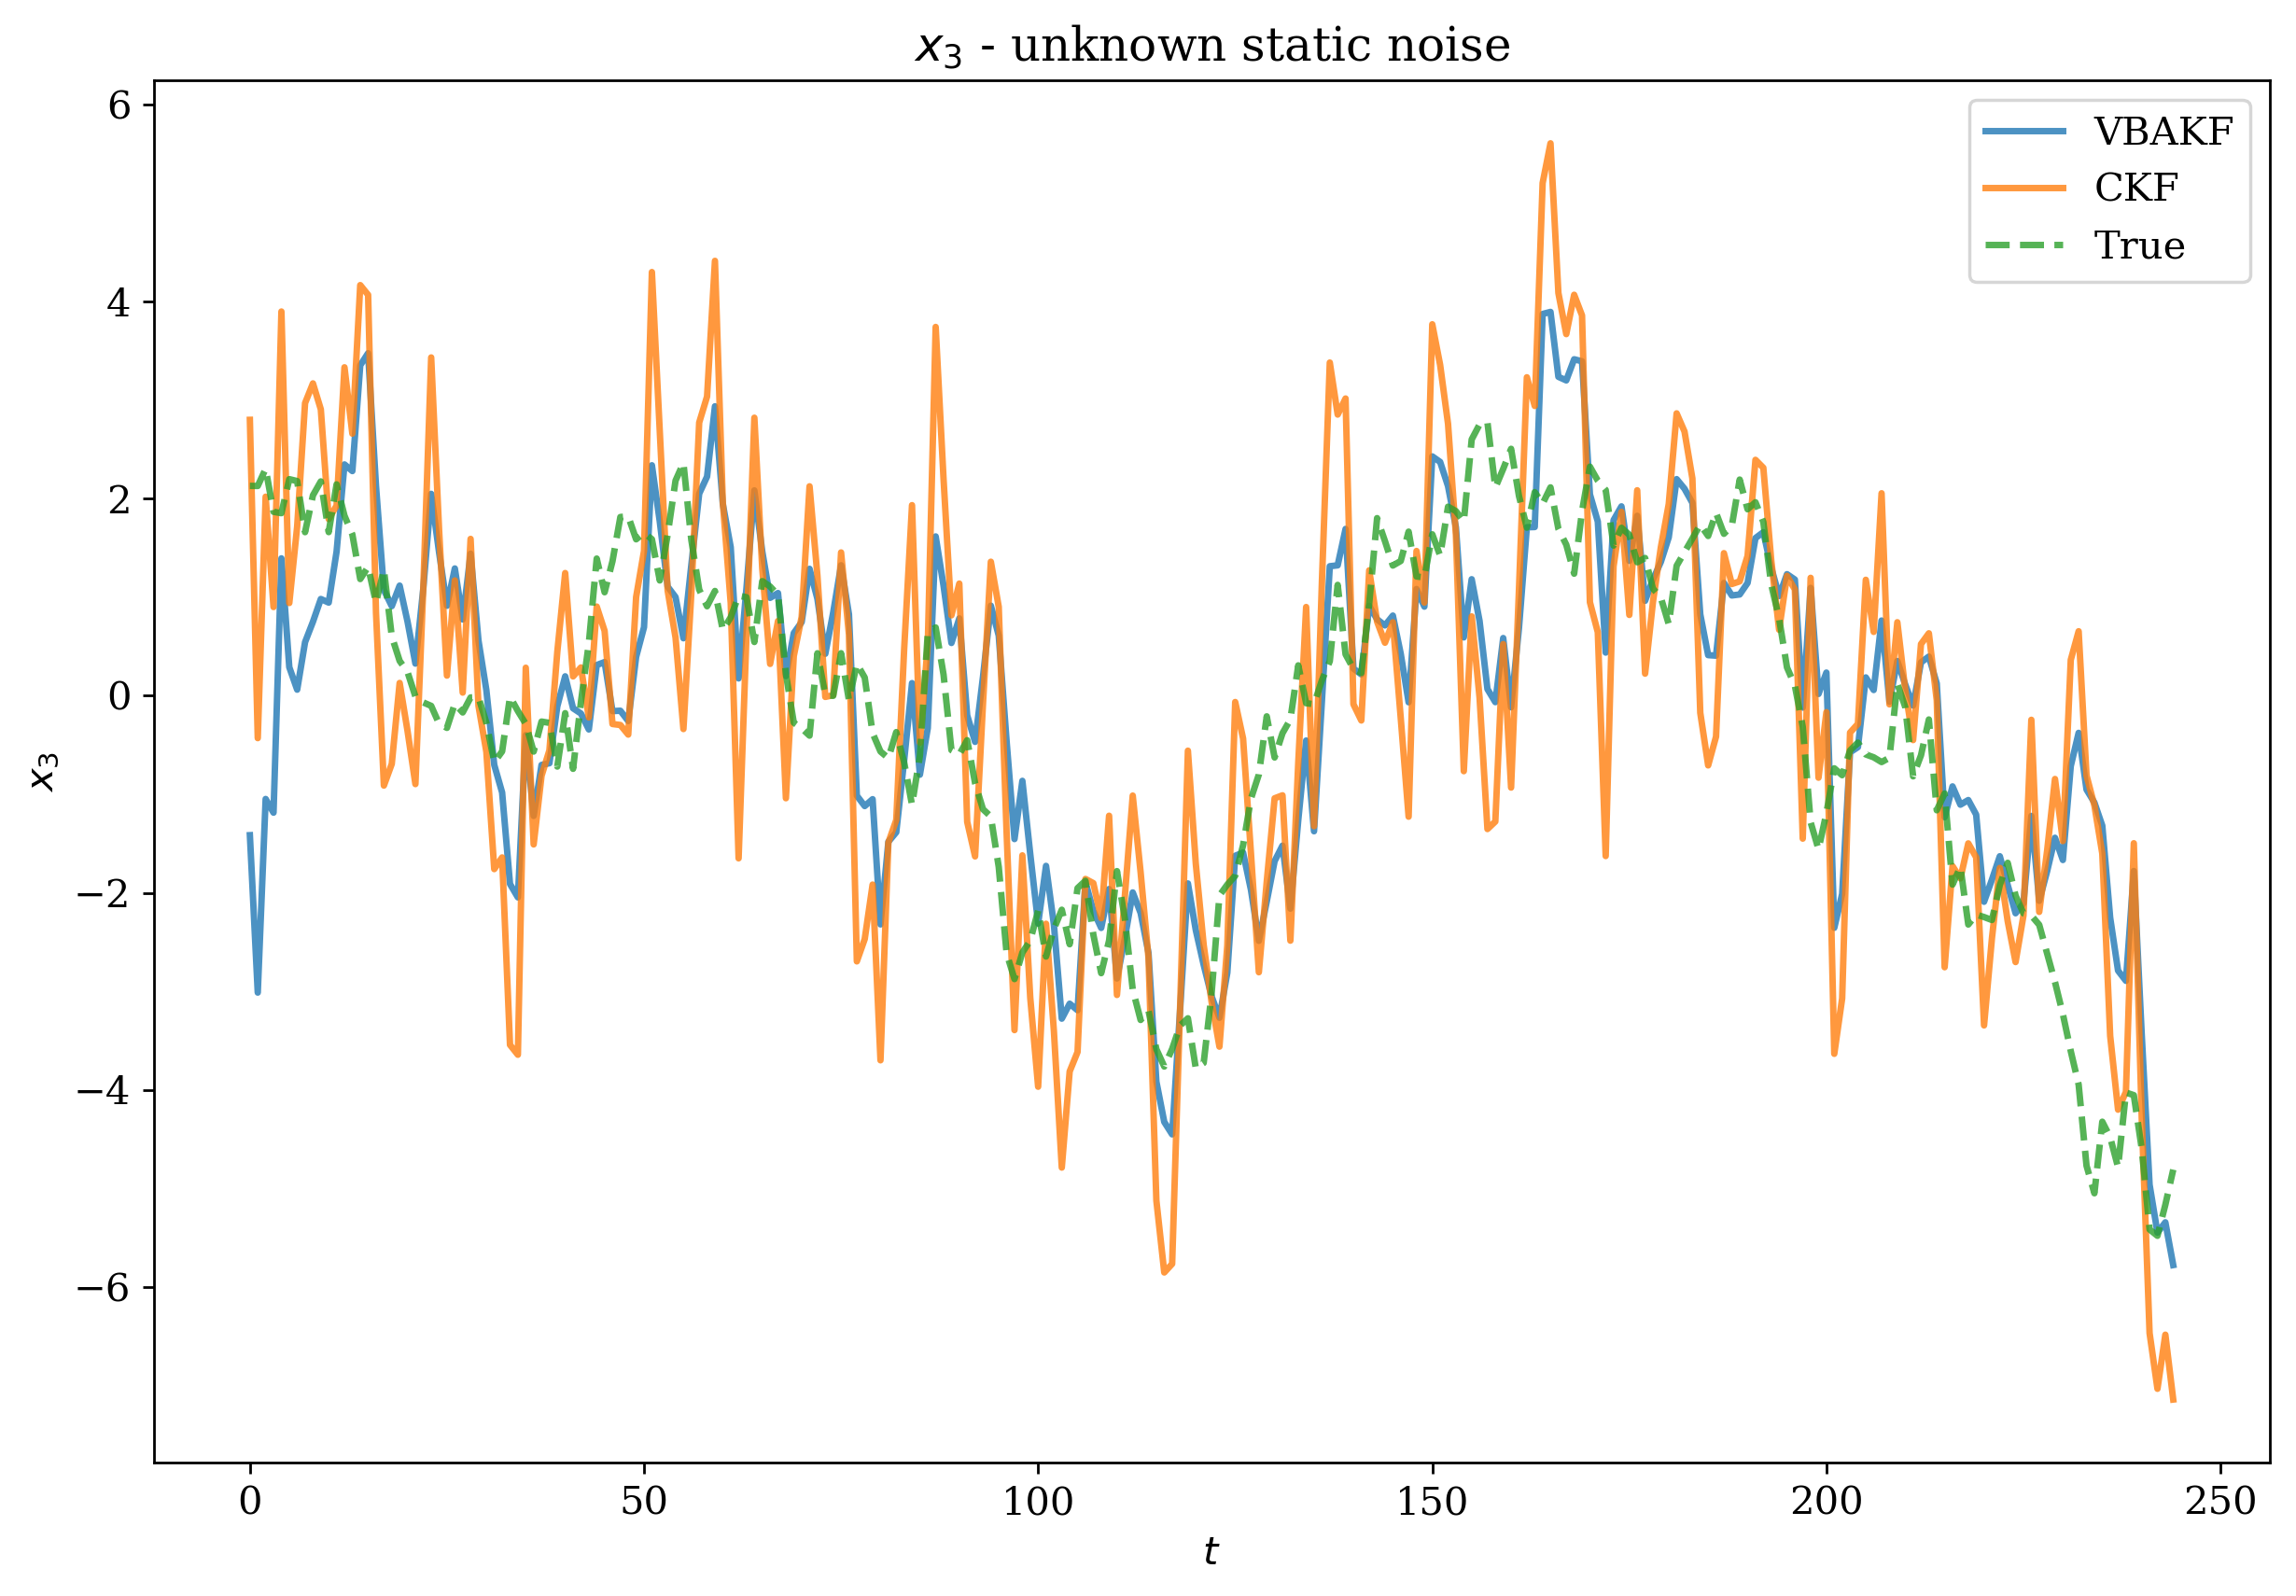

In [22]:
plot_comp(plt, 2, res_dv, res_kfc, true_traj, msrms=None, title='$x_3$ - unknown static noise', 
          ylabel='$x_3$', 
          start_pos=5)
savef('perf-static-unknown-x3.pdf')

# Sinus variable noise

In [23]:
suffix_text = "Unknown variable noise"
x1_text = "$x_1$"
x3_text = "$x_3$"
x1_sl = 0
x3_sl = 2

In [24]:
np.random.seed(SEED)
s = noise.sin_noise(N, 3)
n_sin = noise.static_noise(N, mod=5) * s

cov_init = abs(cov_traj) #+ np.cov(n_sin.T)
msrms = trj.Y + n_sin.T

res_dv, rms_dv, std_dv = daniels_variant(msrms, true_traj, cov_init, rho=0.9)
res_kfc, rms_kfc, srd_kfc  = classic_kf(trj, msrms, true_traj, cov_init)
print(rms_dv, std_dv)
print(rms_kfc, srd_kfc)

[0.51715205 0.54838627 0.97704287 0.92180027] [0.46245315 0.40230963 0.82003607 0.78353971]
[0.63331474 0.65088228 1.39689037 1.34230168] [0.57557246 0.52737446 1.12696538 1.08599235]


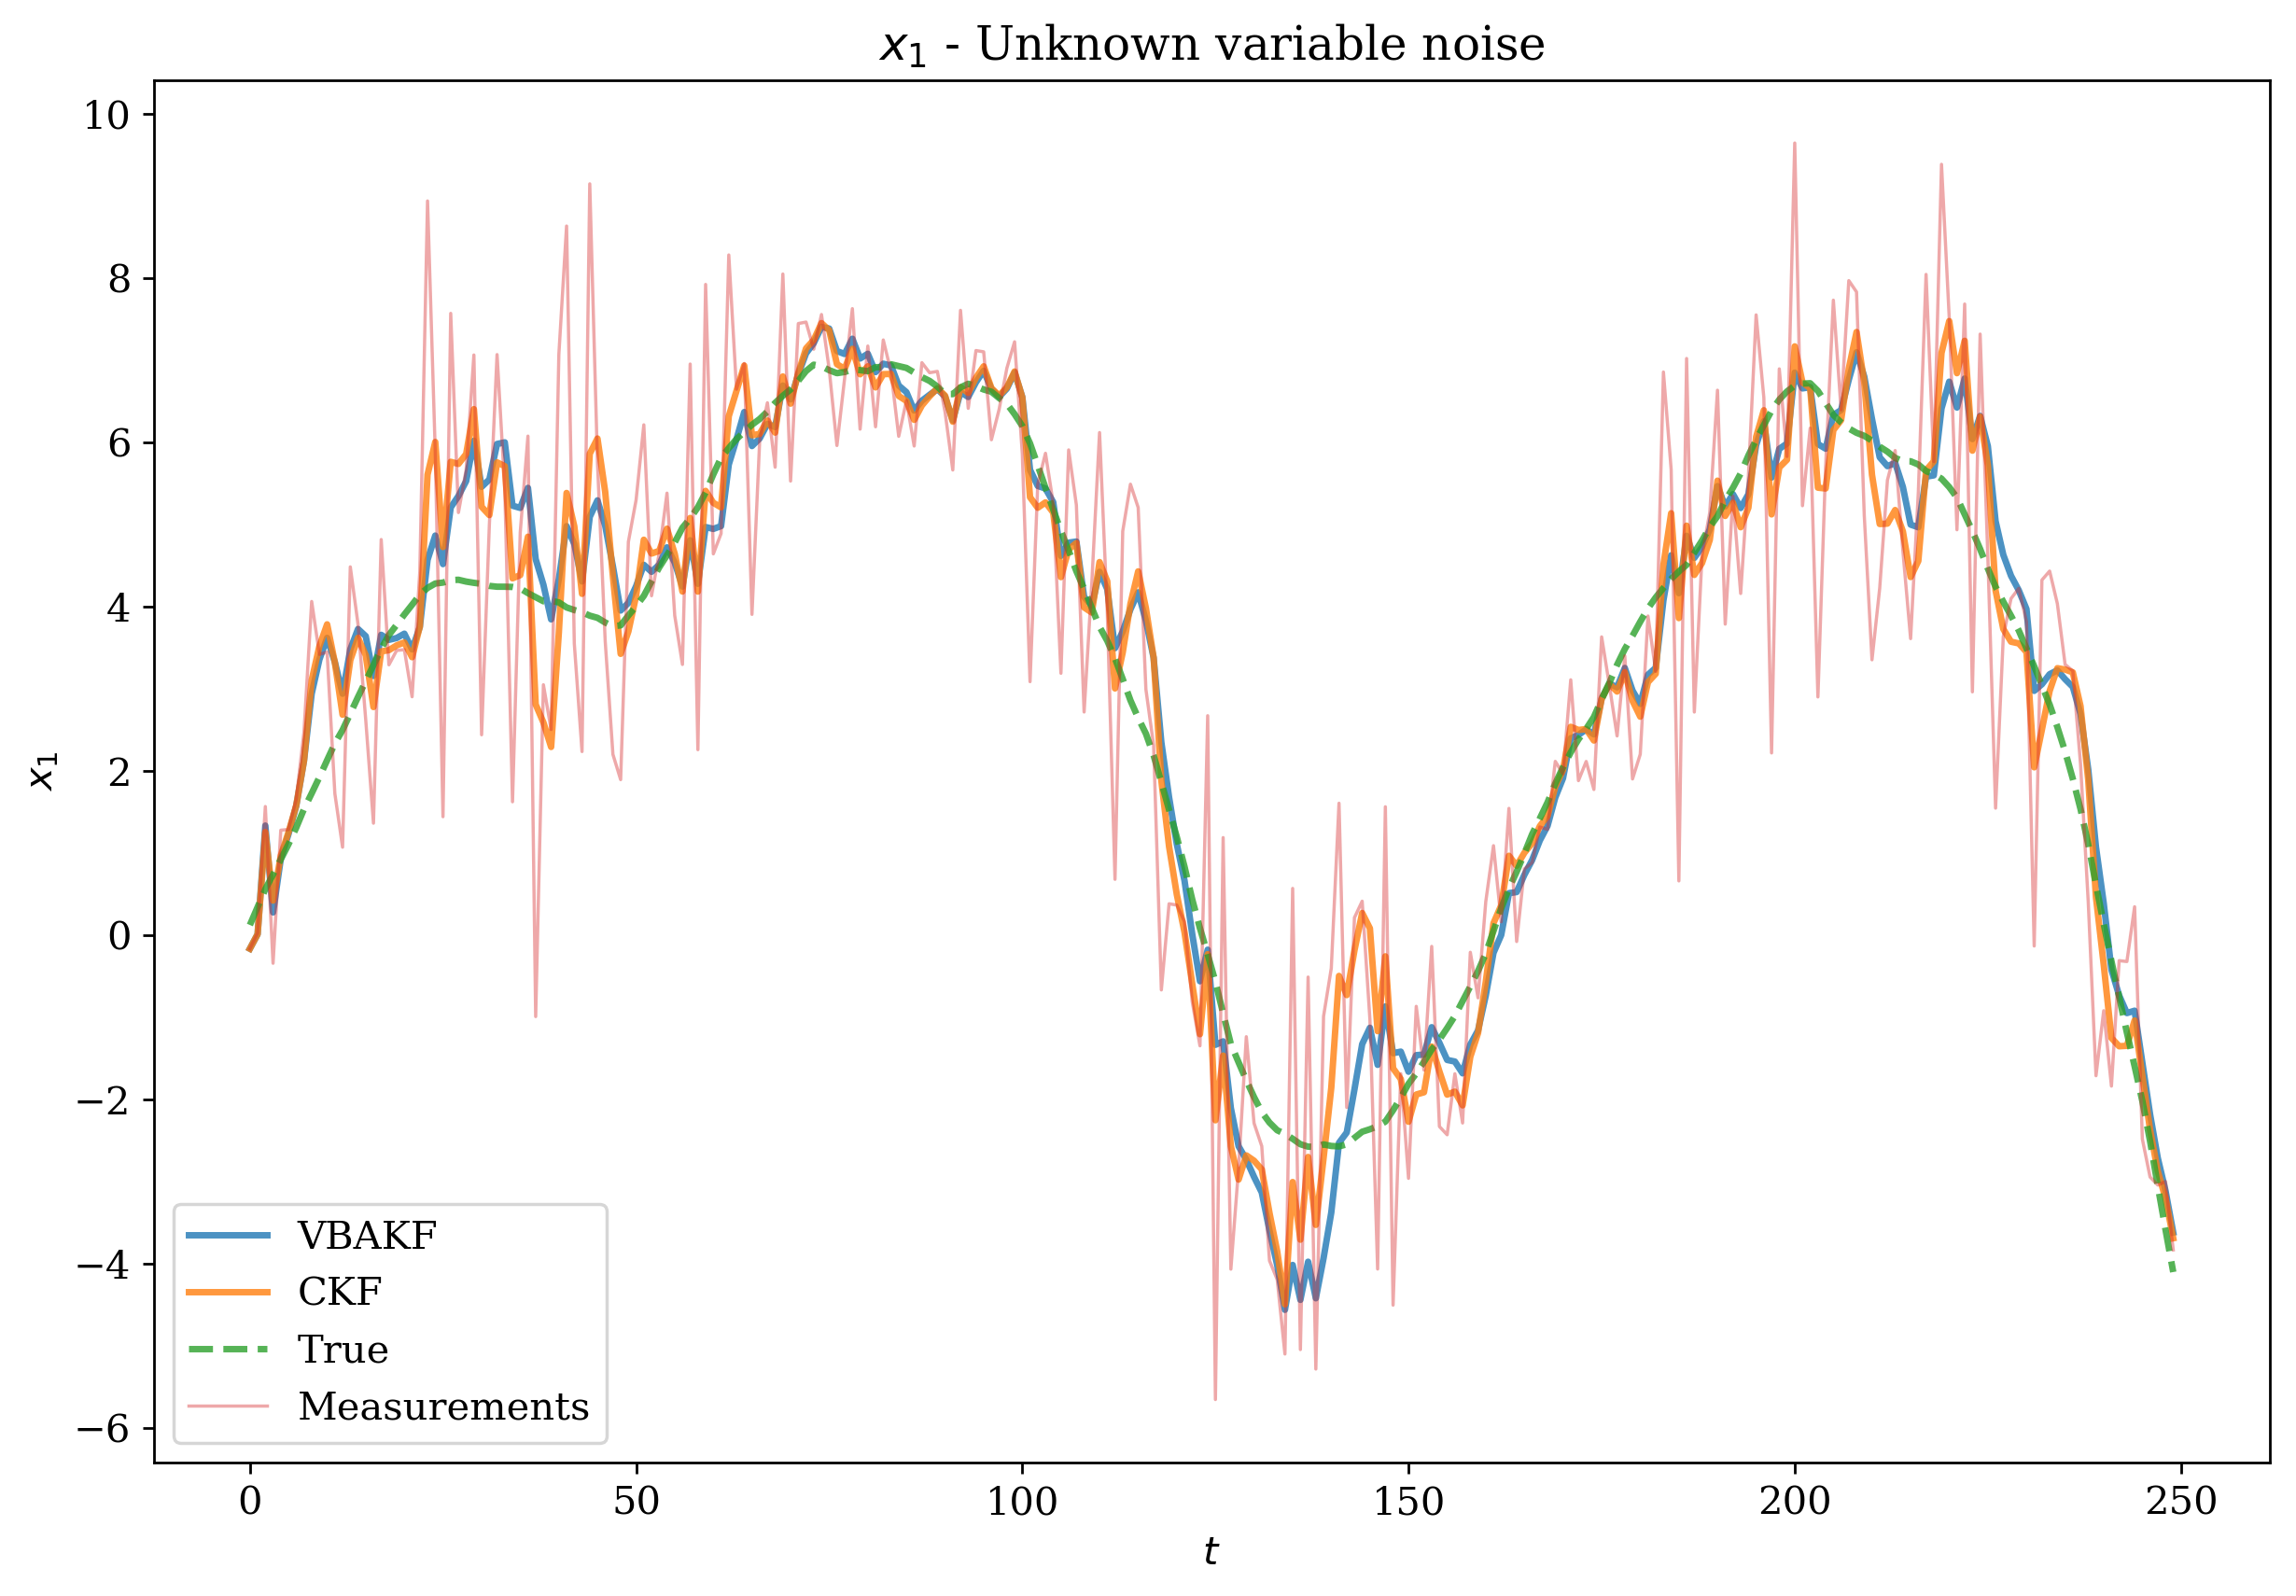

In [25]:
plot_comp(plt, x1_sl, res_dv, res_kfc, true_traj, msrms, x1_text + ' - ' + suffix_text, x1_text)
savef('perf-static-sinus-x1.pdf')

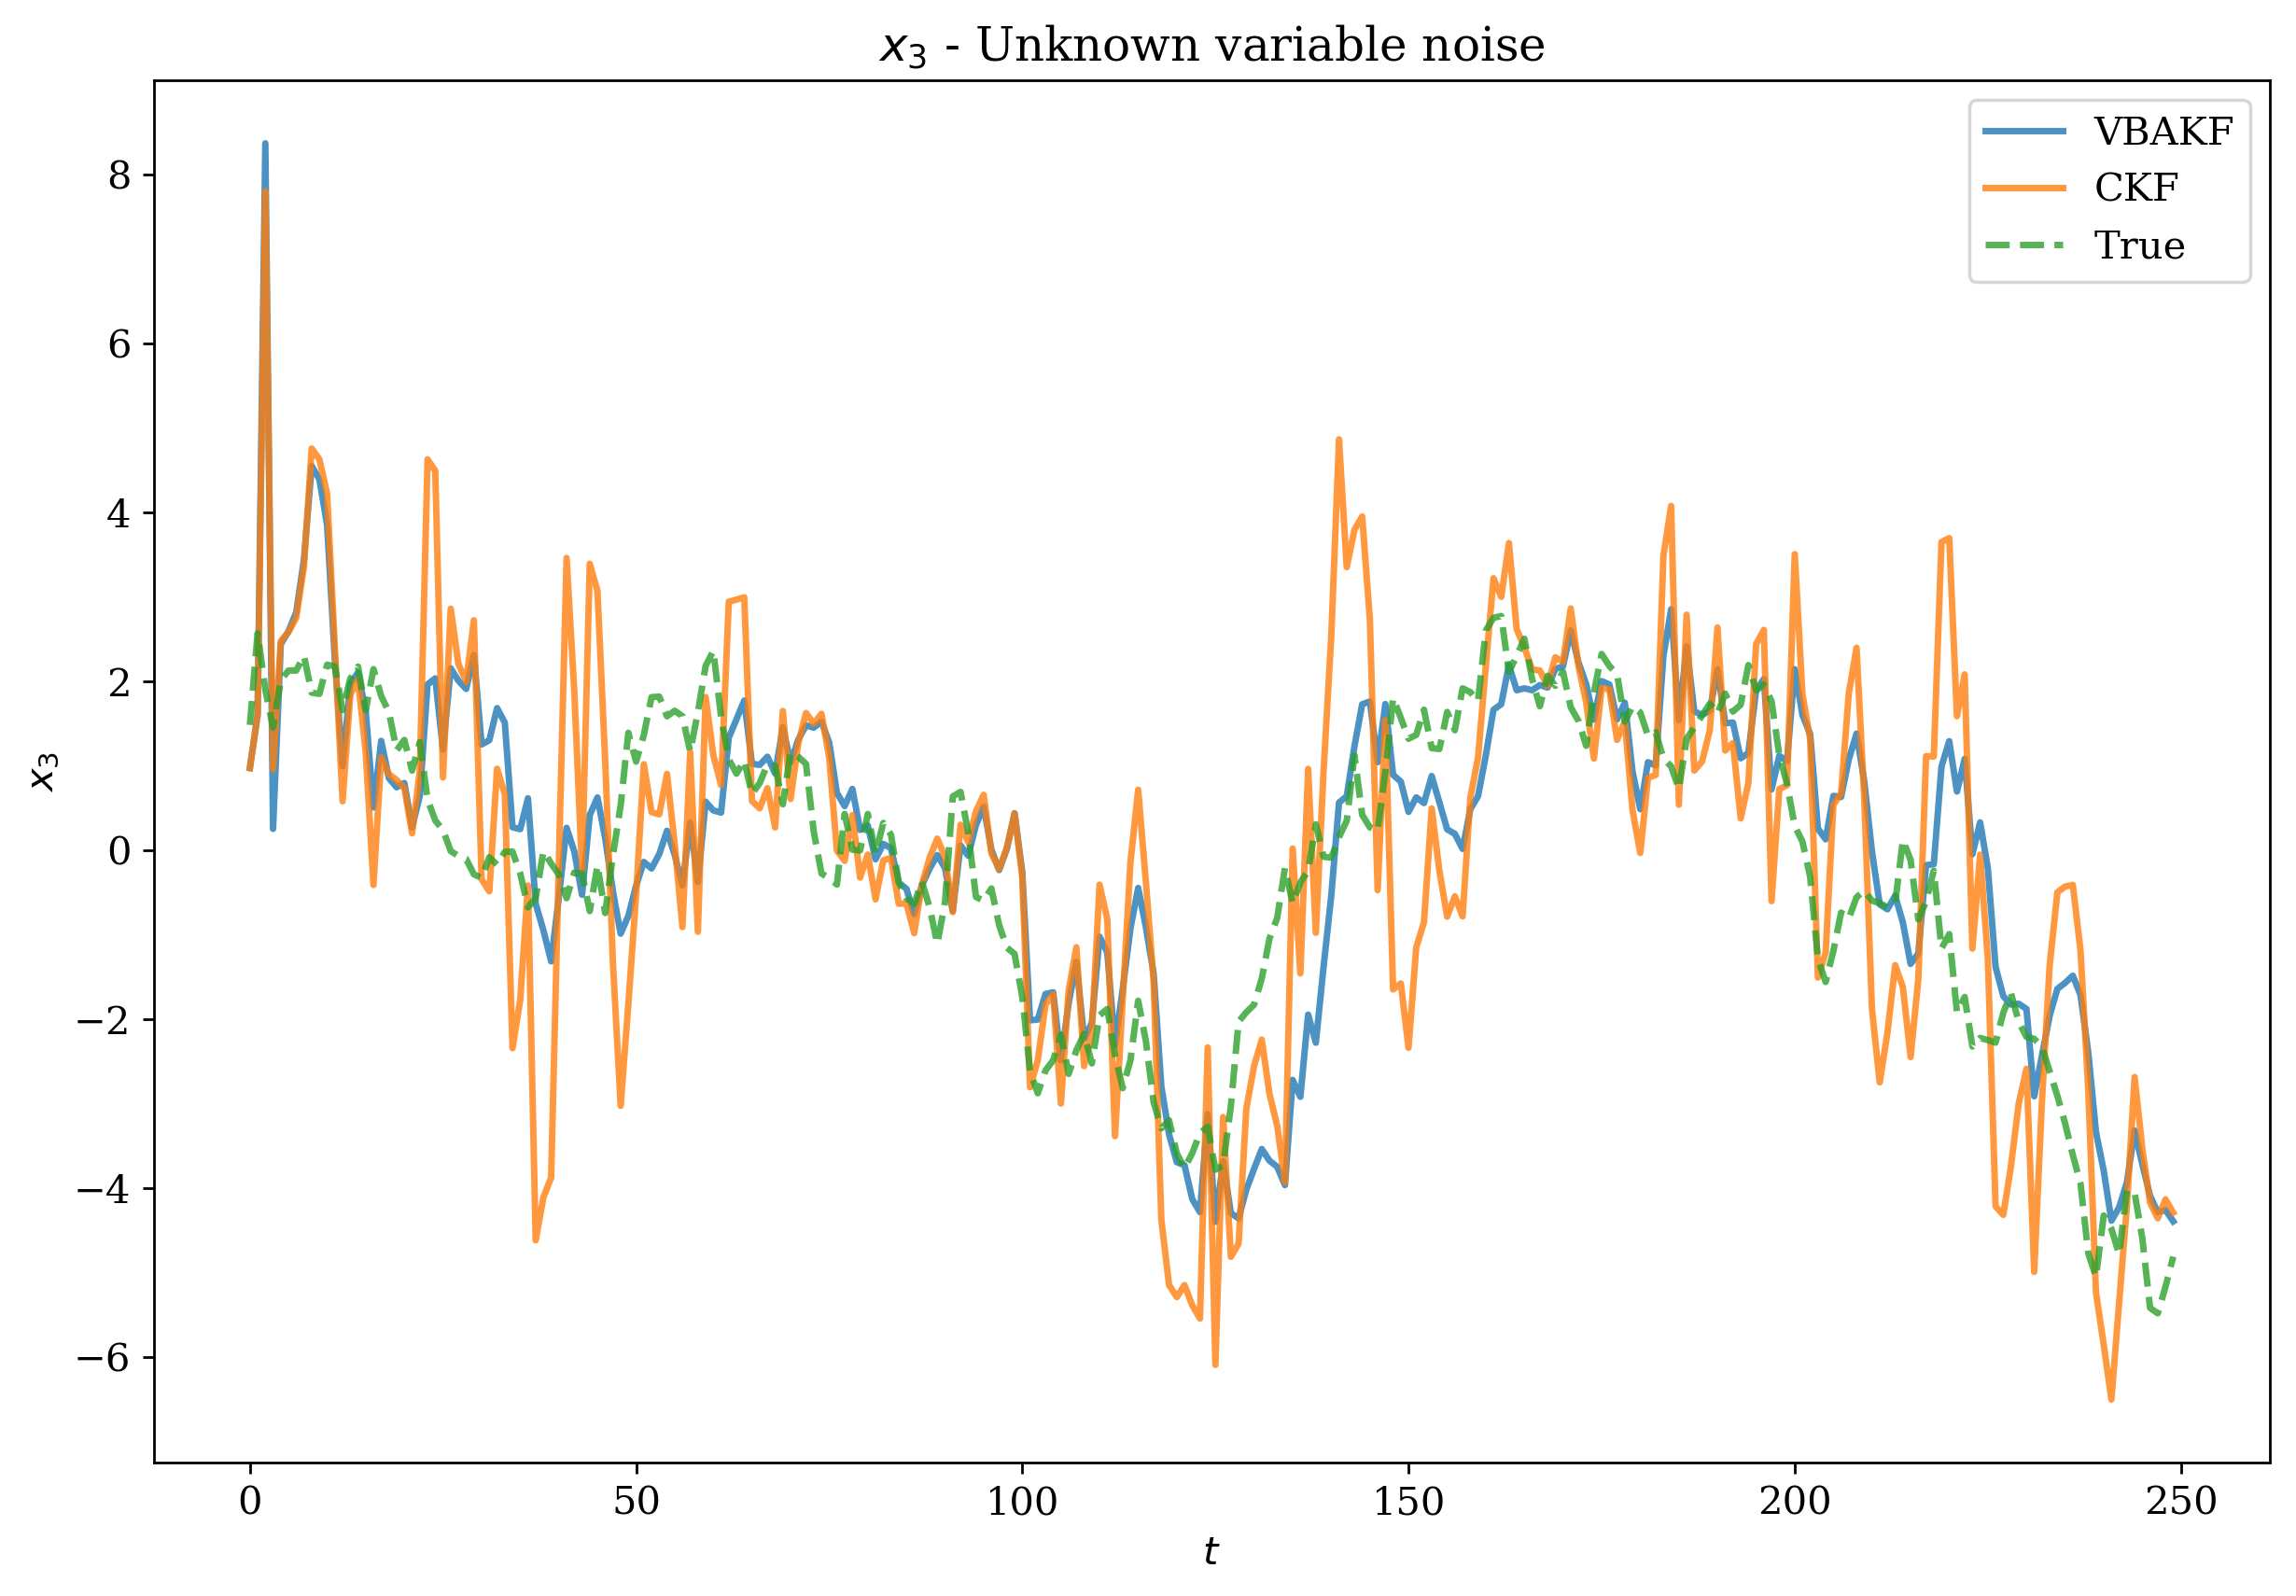

In [26]:
plot_comp(plt, x3_sl, res_dv, res_kfc, true_traj, msrms=None, title=x3_text + ' - ' + suffix_text, ylabel=x3_text)
savef('perf-static-sinus-x3.pdf')

### Frobeniova norma - vzdálenost od původní matice

In [27]:
def rolling_window(a, shape):  # rolling window for 2D array
    s = (a.shape[0] - shape[0] + 1,) + (a.shape[1] - shape[1] + 1,) + shape
    strides = a.strides + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=s, strides=strides)

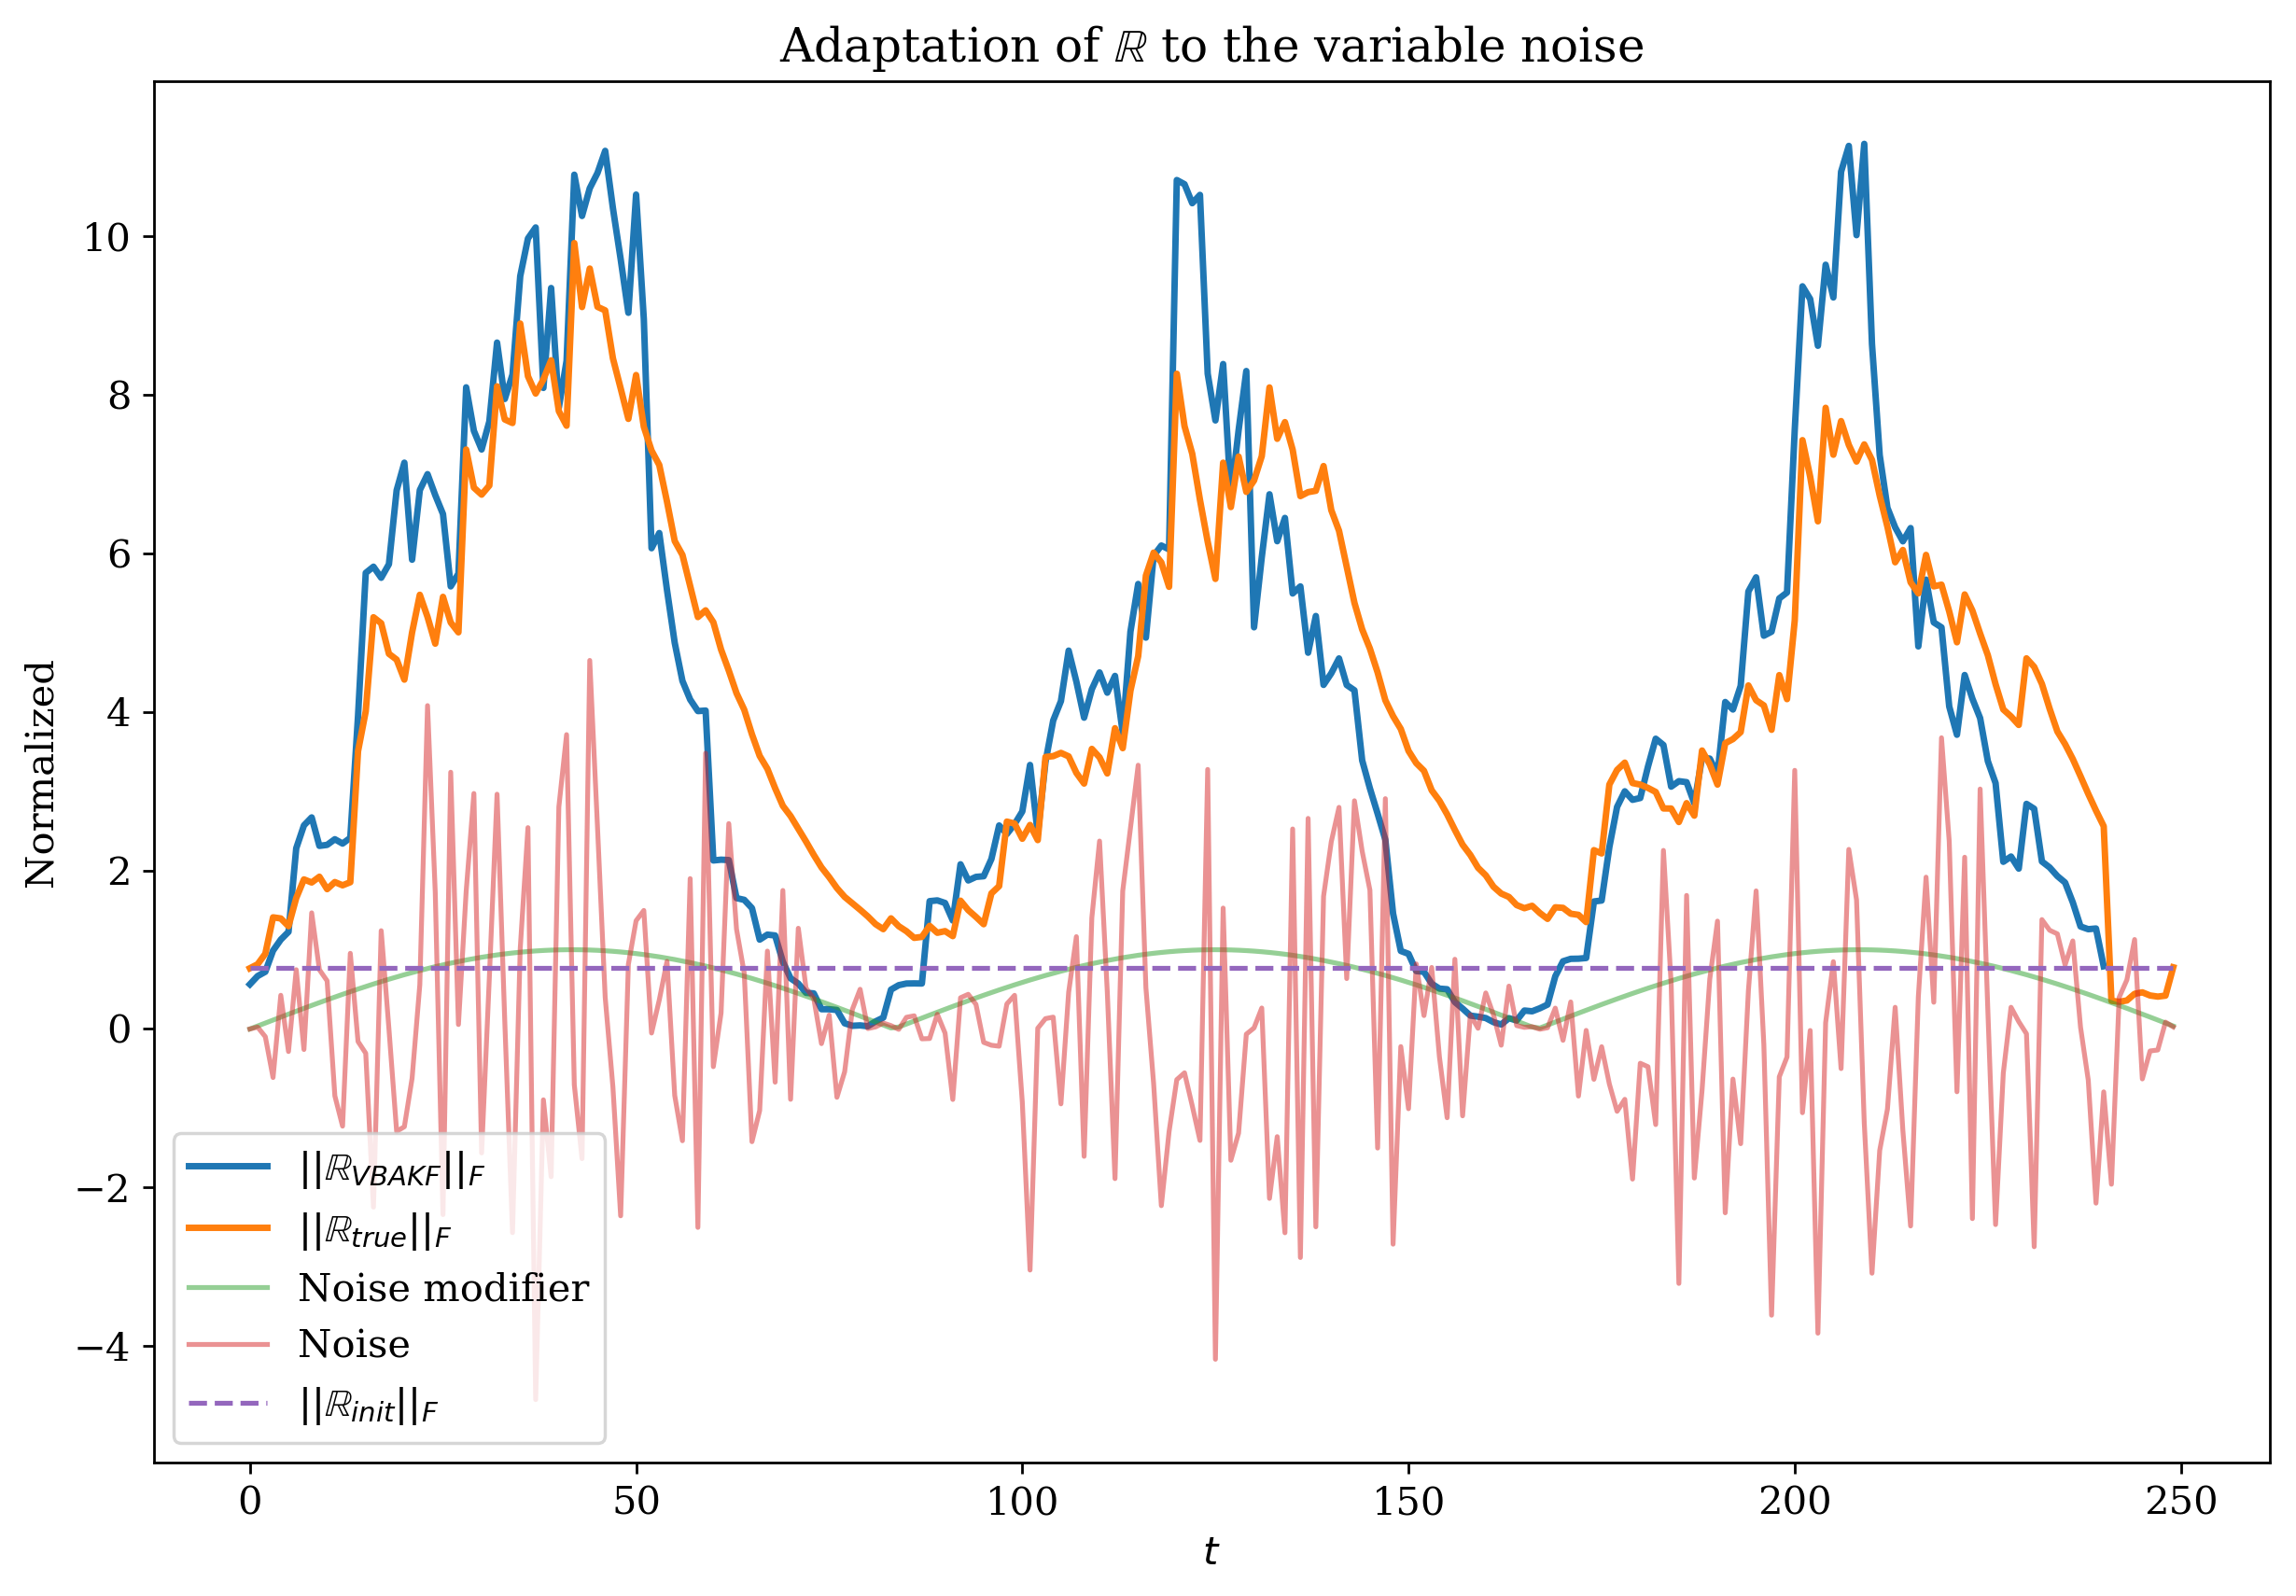

In [28]:
res_dv, rms_dv, std_dv, nd = daniels_variant(msrms, true_traj, cov_init, rho=0.9, debug=True)
rn = nd.norm_r()
true_rn = nd.norm_r() + np.linalg.norm(np.cov(n_sin.T))

rs = np.array([np.linalg.norm(np.cov(x[0].T)) for x in 
               rolling_window(n_sin, (10, 2))])
# have to roll it because of the rolling window shift
rn = np.roll(rn, -9)

plt.plot(rs, label='$||\mathbb{R}_{VBAKF}||_F$', lw=2)
plt.plot(rn, label='$||\mathbb{R}_{true}||_F$', lw=2)
plt.plot(abs(s[:, 0]), label='Noise modifier', alpha=0.5)
plt.plot(n_sin[:, 0], label='Noise', alpha=0.5)
plt.plot([rn[0]]*N, label='$||\mathbb{R}_{init}||_F$', linestyle='--')
plt.xlabel('$t$')
plt.ylabel('Normalized')
plt.title('Adaptation of $\mathbb{R}$ to the variable noise')
plt.legend()
savef('adaptation-of-r.pdf')